# Analysis of tuning curve modulation by optogenetic stimuli on top of drifting grating stimulus
- Different levels of opto depolarization strength ("opto_depol_pct")
- Different contrast levels ("contrast_levels")
- Sigmoidal curve fits to quantify modulation of tuning curves

Requirements:
- "single_cell_psths" launched with bbp-workflow
- PSTH data for PV, SOM, and PYR cells

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.metrics import r2_score
from bluepy import Cell, Synapse, Circuit, Simulation
import os
import pickle
import tqdm
import voxcell
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message='invalid value encountered in double_scalars')
warnings.filterwarnings('ignore', message='Mean of empty slice')

In [2]:
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/4318c9a4-efc0-4f7d-b3e9-8b3833c65bfd/analyses/simulations.pkl' # (Revised) Conductance based settings from 18/01/2023, Ca1.05, param set 41, hex0_PV only, 100% sub-fraction, 0-300% opto intensities, full tuning curves

sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/1bc6b009-9bad-4e6c-b0c0-b59138a540e3/analyses/simulations.pkl' # Conductance based settings from 18/01/2023, Ca1.05, param set 41, hex0_PV only, 100% sub-fraction, 0-300% opto intensities, full tuning curves
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/2967e471-5716-41ed-b628-15d58d5e2ede/analyses/simulations.pkl' # Conductance based settings from 18/01/2023, Ca1.05, param set 41, hex0_SOM only, 100% sub-fraction, 0-300% opto intensities, full tuning curves

# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/70adfc43-8848-4d3a-8e1a-3042a1a5fd77/analyses/simulations.pkl' # Conductance based, Ca1.05, param set 58, hex0_PV only, 100% sub-fraction, 0-100% opto intensities, full tuning curves
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/847083ee-2235-4226-b504-968be31414eb/analyses/simulations.pkl' # Conductance based, Ca1.05, param set 58, hex0_SOM only, 100% sub-fraction, 0-100% opto intensities, full tuning curves

# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/ce41c578-6158-4b46-adca-deaff4b2f5af/analyses/simulations.pkl' # Conductance based, Ca1.05, param set 58, hex0_PV only, 50% sub-fraction, 0-100% opto intensities, full tuning curves
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/9d7ce11c-a705-48ce-a717-e0dfda70be11/analyses/simulations.pkl' # Conductance based, Ca1.05, param set 58, hex0_SOM only, 50% sub-fraction, 0-100% opto intensities, full tuning curves

sims = pd.read_pickle(sims_file)
num_sims = len(sims)
circuit = Simulation(sims.iloc[0]).circuit

res_path = os.path.join(os.path.split(sims_file)[0], 'output')
save_path = os.path.join(os.path.split(sims_file)[0], 'visual_contrast_tuning_analysis')
if not os.path.exists(save_path):
    os.makedirs(save_path)

Have keys ({'desired_unconnected_fr_L4I', 'desired_connected_fr_L6I', 'desired_connected_fr_L6E', 'desired_connected_fr_L4E', 'desired_connected_fr_L5E', 'desired_unconnected_fr_L6E', 'desired_unconnected_fr_L1I', 'desired_connected_fr_L1I', 'desired_connected_proportion_of_invivo_frs', 'desired_unconnected_fr_L4E', 'desired_unconnected_fr_L6I', 'depol_stdev_mean_ratio', 'desired_connected_fr_L23E', 'desired_unconnected_fr_L5E', 'desired_unconnected_fr_L23E', 'desired_connected_fr_L5I', 'desired_unconnected_fr_L23I', 'desired_unconnected_fr_L5I', 'desired_connected_fr_L23I', 'desired_connected_fr_L4I'}) that are not defined for section: Run


### Load PSTH data

In [3]:
# Load PSTH results ("single_cell_psths" launched with bbp-workflow)
psth_res_name = 'single_cell_psths'
name_suffix = '__hex0'

psth_data_PYR = {}
psth_data_PV = {}
psth_data_SOM = {}
cond_names = sims.index.names
for sim_idx, (cond, cfg_path) in enumerate(sims.iteritems()):
    cond_dict = dict(zip(cond_names, cond))
    sim_id = os.path.split(os.path.split(cfg_path)[0])[-1] # Subfolder name (i.e., 000, 001, ...)
    sim_spec = '__'.join([f'{k}_{v}' for k, v in cond_dict.items()]) # Sim conditions (e.g., sparsity_1.0__rate_bk_0.2__rate_max_10.0)

    res_file = os.path.join(res_path, psth_res_name, f'{psth_res_name}{name_suffix}_PYR__SIM{sim_id}__{sim_spec}.pickle')
    assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
    with open(res_file, 'rb') as f:
        res = pickle.load(f)
    psth_data_PYR[sim_idx] = res

    res_file = os.path.join(res_path, psth_res_name, f'{psth_res_name}{name_suffix}_PV__SIM{sim_id}__{sim_spec}.pickle')
    assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
    with open(res_file, 'rb') as f:
        res = pickle.load(f)
    psth_data_PV[sim_idx] = res

    res_file = os.path.join(res_path, psth_res_name, f'{psth_res_name}{name_suffix}_SOM__SIM{sim_id}__{sim_spec}.pickle')
    assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
    with open(res_file, 'rb') as f:
        res = pickle.load(f)
    psth_data_SOM[sim_idx] = res

tuning_property = sims.index.names[np.where(np.array(sims.index.levshape) > 1)[0][0]]
print(f'Tuning property: {tuning_property}')

Tuning property: opto_depol_pct


In [4]:
# Get opto depolarization & contrast levels
opto_depol_pct = None
contrasts = None
for psth_data in [psth_data_PYR, psth_data_PV, psth_data_SOM]:
    pct_tmp = [psth_data[sidx]['opto_cfg']['cfg']['opto_depol_pct'] for sidx in range(len(psth_data))]
    ctr_tmp = psth_data[0]['stim_cfg']['cfg']['contrast_levels']
    if opto_depol_pct is None:
        opto_depol_pct = pct_tmp
    else:
        assert np.array_equal(opto_depol_pct, pct_tmp), 'ERROR: "opto_depol_pct" not consistent!'
    if contrasts is None:
        contrasts = ctr_tmp
    else:
        assert np.array_equal(contrasts, ctr_tmp), 'ERROR: "contrast_levels" not consistent!'
print(f'opto_depol_pct = {opto_depol_pct}')
print(f'contrasts = {contrasts}')

opto_depol_pct = [0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0]
contrasts = [0.06, 0.12, 0.24, 0.5, 1.0]


### Compute (normalized) tuning curves

In [5]:
# Compute tuning curves
def compute_tuning(psth_data, resp_int, base_int, do_norm=False, norm_contrast=None, norm_opto=None, norm_once=None):
    """Computes single-cell tuning with or without normalization"""

    sim_ids = list(psth_data.keys())
    contrasts = None # Contrast levels
    tuning_curves = [] # Normalized tuning curves
    baselines = [] # Normalized baseline activities
    gids = []
    norm_rates = []
    print('PROCESSING tuning curves...', end='')
    for sim_idx in sim_ids:
        print(f' {sim_idx}', end='')

        if contrasts is None:
            contrasts = psth_data[sim_idx]['stim_cfg']['cfg']['contrast_levels']
        else:
            assert np.all(np.array(contrasts) == psth_data[sim_idx]['stim_cfg']['cfg']['contrast_levels'])

        t_rate = psth_data[sim_idx]['t_rate']
        num_patterns = int(len(psth_data[sim_idx]['rates']) / 2)
        patt_ind = list(range(num_patterns)) # Indices for raw contrast patterns
        opto_ind = list(range(num_patterns, 2 * num_patterns)) # Indices for contrast patterns with opto stim
        if do_norm:
            assert norm_contrast in contrasts, 'ERROR: Normalisation contrast level not found!'
            norm_idx = np.where(np.array(contrasts) == norm_contrast)[0][0]
            if norm_opto:
                norm_idx = norm_idx + len(contrasts) # Pattern with opto stim

        if len(gids) == 0:
            gids = psth_data[sim_idx]['gids']
            num_cells = len(gids)
        else:
            assert np.array_equal(gids, psth_data[sim_idx]['gids']), 'ERROR: GIDs mismatch across simulations!'
        avg_responses = []
        avg_baseline = []
        norm_responses = [] # Normalized rates based on max. rate at given norm_contrast level (w/o opto!)
        norm_baseline = [] # Normalized baseline rates based on max. rate at given norm_contrast level (w/o opto!)
        for gidx, gid in enumerate(gids):
            resp_rates = []
            base_rates = []
            for p in range(2 * num_patterns):
                spike_trains = psth_data[sim_idx]['spike_trains'][p][gid]
                resp_rates.append([1e3 * np.sum(np.logical_and(np.array(st) >= resp_int[0], np.array(st) < resp_int[-1])) / np.diff(resp_int)[0] for st in spike_trains])
                base_rates.append([1e3 * np.sum(np.logical_and(np.array(st) >= base_int[0], np.array(st) < base_int[-1])) / np.diff(base_int)[0] for st in spike_trains])
            avg_responses.append(resp_rates)
            avg_baseline.append(base_rates)
            if do_norm:
                norm_rate = np.mean(resp_rates[norm_idx]) # Maximum rate used for normalization
                if norm_once:
                    if len(norm_rates) == len(gids):
                        norm_rate = norm_rates[gidx]
                    else:
                        norm_rates.append(norm_rate)
            else:
                norm_rate = 1.0 # No normalization
            norm_responses.append([[r / norm_rate if norm_rate > 0.0 else np.nan for r in resp_rates[p]] for p in range(2 * num_patterns)])
            norm_baseline.append([[r / norm_rate if norm_rate > 0.0 else np.nan for r in base_rates[p]] for p in range(2 * num_patterns)])

        def resp_stat(responses, fct):
            """Computes statistics given by fct over response trials"""
            return np.array([[fct(r) if len(r) > 0 else np.nan for r in rr] for rr in responses])

        contr_resp_func = {}
        contr_resp_func.update({'mean': resp_stat(norm_responses, np.mean)})
        contr_resp_func.update({'std': resp_stat(norm_responses, np.std)})
        contr_resp_func.update({'N': resp_stat(norm_responses, len)})
        contr_resp_func.update({'sem': contr_resp_func['std'] / np.sqrt(contr_resp_func['N'])})

        baseline_activity = {}
        baseline_activity.update({'mean': resp_stat(norm_baseline, np.mean)})
        baseline_activity.update({'std': resp_stat(norm_baseline, np.std)})
        baseline_activity.update({'N': resp_stat(norm_baseline, len)})
        baseline_activity.update({'sem': baseline_activity['std'] / np.sqrt(baseline_activity['N'])})

        tuning_curves.append(contr_resp_func)
        baselines.append(baseline_activity)

    return tuning_curves, baselines, gids

In [102]:
# Compute (normalized) PYR tuning...
# tuning_curves_PYR, baselines_PYR, gids_PYR = compute_tuning(psth_data_PYR, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=False)
# np.savez(os.path.join(save_path, 'tuning_curves_PYR.npz'), tuning_curves_PYR=tuning_curves_PYR, baselines_PYR=baselines_PYR, gids_PYR=gids_PYR)
# norm_tuning_curves_PYR, norm_baselines_PYR, gids_PYR = compute_tuning(psth_data_PYR, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=True, norm_contrast=1.0, norm_opto=True, norm_once=True)
# np.savez(os.path.join(save_path, 'norm_tuning_curves_PYR.npz'), norm_tuning_curves_PYR=norm_tuning_curves_PYR, norm_baselines_PYR=norm_baselines_PYR, gids_PYR=gids_PYR)

# ...OR load from file
tuning_data = np.load(os.path.join(save_path, 'tuning_curves_PYR.npz'), allow_pickle=True)
tuning_curves_PYR = list(tuning_data['tuning_curves_PYR'])
baselines_PYR = list(tuning_data['baselines_PYR'])
gids_PYR = tuning_data['gids_PYR']
del tuning_data
tuning_data = np.load(os.path.join(save_path, 'norm_tuning_curves_PYR.npz'), allow_pickle=True)
norm_tuning_curves_PYR = list(tuning_data['norm_tuning_curves_PYR'])
norm_baselines_PYR = list(tuning_data['norm_baselines_PYR'])
assert np.array_equal(gids_PYR, tuning_data['gids_PYR']), 'ERROR: PYR GIDs mismatch!'
del tuning_data

In [103]:
# Compute (normalized) PV tuning...
# tuning_curves_PV, baselines_PV, gids_PV = compute_tuning(psth_data_PV, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=False)
# np.savez(os.path.join(save_path, 'tuning_curves_PV.npz'), tuning_curves_PV=tuning_curves_PV, baselines_PV=baselines_PV, gids_PV=gids_PV)
# norm_tuning_curves_PV, norm_baselines_PV, gids_PV = compute_tuning(psth_data_PV, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=True, norm_contrast=1.0, norm_opto=True, norm_once=True)
# np.savez(os.path.join(save_path, 'norm_tuning_curves_PV.npz'), norm_tuning_curves_PV=norm_tuning_curves_PV, norm_baselines_PV=norm_baselines_PV, gids_PV=gids_PV)

# ...OR load from file
tuning_data = np.load(os.path.join(save_path, 'tuning_curves_PV.npz'), allow_pickle=True)
tuning_curves_PV = list(tuning_data['tuning_curves_PV'])
baselines_PV = list(tuning_data['baselines_PV'])
gids_PV = tuning_data['gids_PV']
del tuning_data
tuning_data = np.load(os.path.join(save_path, 'norm_tuning_curves_PV.npz'), allow_pickle=True)
norm_tuning_curves_PV = list(tuning_data['norm_tuning_curves_PV'])
norm_baselines_PV = list(tuning_data['norm_baselines_PV'])
assert np.array_equal(gids_PV, tuning_data['gids_PV']), 'ERROR: PV GIDs mismatch!'
del tuning_data

In [104]:
# Compute normalized SOM tuning...
# tuning_curves_SOM, baselines_SOM, gids_SOM = compute_tuning(psth_data_SOM, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=False)
# np.savez(os.path.join(save_path, 'tuning_curves_SOM.npz'), tuning_curves_SOM=tuning_curves_SOM, baselines_SOM=baselines_SOM, gids_SOM=gids_SOM)
# norm_tuning_curves_SOM, norm_baselines_SOM, gids_SOM = compute_tuning(psth_data_SOM, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=True, norm_contrast=1.0, norm_opto=True, norm_once=True)
# np.savez(os.path.join(save_path, 'norm_tuning_curves_SOM.npz'), norm_tuning_curves_SOM=norm_tuning_curves_SOM, norm_baselines_SOM=norm_baselines_SOM, gids_SOM=gids_SOM)

# ...OR load from file
tuning_data = np.load(os.path.join(save_path, 'tuning_curves_SOM.npz'), allow_pickle=True)
tuning_curves_SOM = list(tuning_data['tuning_curves_SOM'])
baselines_SOM = list(tuning_data['baselines_SOM'])
gids_SOM = tuning_data['gids_SOM']
del tuning_data
tuning_data = np.load(os.path.join(save_path, 'norm_tuning_curves_SOM.npz'), allow_pickle=True)
norm_tuning_curves_SOM = list(tuning_data['norm_tuning_curves_SOM'])
norm_baselines_SOM = list(tuning_data['norm_baselines_SOM'])
assert np.array_equal(gids_SOM, tuning_data['gids_SOM']), 'ERROR: SOM GIDs mismatch!'
del tuning_data

In [105]:
def plot_mean_modulated_contrast_response_function_per_layer(tuning_curves, baselines, gids, circuit, contrasts, tuning_values, merged_layers=None, save_path=None, save_spec=None, num_y_zoom=None, tuning_property=None, title_spec=None):
    """Plot contrast response functions (norm. contrast tuning curves) modulated by opto stim"""
    num_sims = len(tuning_values)
    num_patterns = len(contrasts)
    pidx = np.arange(num_patterns) + num_patterns # Pattern indices with opto stim (i.e., starting at <num_patterns>)

    layers = list(np.unique(circuit.cells.get(gids, properties='layer')))
    if merged_layers is not None:
        for mlay in merged_layers: # List of lists expeted
            layers = list(np.setdiff1d(layers, mlay)) # Remove single layers from list
            layers.append(mlay) # Add merged layers to list
            layers = sorted(layers, key=lambda x: x[0] if isinstance(x, list) else x) # Re-sort based on first of merged layers

    plt.figure(figsize=(12, 3))
    for lidx, layer in enumerate(layers):
        plt.subplot(1, len(layers), lidx + 1)
        gids_sel = gids[np.isin(circuit.cells.get(gids, properties='layer'), layer)]

        depol_colors = plt.cm.viridis(np.linspace(0, 1, num_sims))
        gid_idx = np.where(np.isin(gids, gids_sel))[0]
        gid_idx = gid_idx[~np.any(np.isnan(baselines[0]['mean'][gid_idx, :][:, pidx]), 1)] # Remove (non-responding) GIDs with invalid norm. tuning
        assert len(gid_idx) > 0, 'ERROR: No GIDs selected!'
        for sidx in range(num_sims):
            if tuning_property is not None and '_pct' in tuning_property:
                lbl = f'{tuning_values[sidx]}%'
            else:
                lbl = f'{tuning_values[sidx]}'
            if tuning_values[sidx] == 0.0:
                plt.errorbar(range(num_patterns + 1), np.hstack((np.mean(baselines[sidx]['mean'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0))), yerr=np.hstack((np.mean(baselines[sidx]['sem'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0))), color=depol_colors[sidx, :], label=lbl)
            else:
                plt.errorbar(range(1, num_patterns + 1), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0), yerr=np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0), color=depol_colors[sidx, :], label=lbl)
        plt.xlim((-0.25, num_patterns + 0.25))
        if num_y_zoom is not None:
            pidx_sel = np.arange(num_y_zoom) + num_patterns
            zoomed_data_min = [np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx_sel], 0) - np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx_sel], 0) for sidx in range(num_sims)]
            zoomed_data_max = [np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx_sel], 0) + np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx_sel], 0) for sidx in range(num_sims)]
            plt.ylim([np.min(zoomed_data_min), np.max(zoomed_data_max)])
        plt.xticks(range(num_patterns + 1), labels=[0.0] + contrasts)
        plt.xlabel('Contrast')
        plt.ylabel('Norm. rate')
        plt.grid()
#         plt.gca().spines['top'].set_visible(False)
#         plt.gca().spines['right'].set_visible(False)
        plt.title(f'L{"".join([str(lay) for lay in layer]) if isinstance(layer, list) else layer} (N={len(gid_idx)})')
    plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5], title=tuning_property)
    if isinstance(title_spec, str):
        title_spec = ' ' + title_spec
    else:
        title_spec = ''
    plt.suptitle('Contrast tuning' + title_spec, fontweight='bold')
    plt.tight_layout()
    if save_path is not None:
        if isinstance(save_spec, str):
            save_spec = '_' + save_spec
        else:
            save_spec = ''
        plt.savefig(os.path.join(save_path, f'mean_norm_contrast_tuning{save_spec}.png'), dpi=300)
    plt.show()


def plot_split_mean_modulated_contrast_response_function_per_layer(tuning_curves, baselines, gids, circuits, opto_props, contrasts, tuning_values, merged_layers=None, tuning_property=None, save_path=None, save_spec=None):
    """Plot contrast response functions (norm. contrast tuning curves) modulated by opto stim,
       splitted into cells that are (not) targeted by opto stimulus"""
    num_sims = len(tuning_values)
    assert len(circuits) == num_sims, f'ERROR: List of {num_sims} circuits required!'
    assert len(opto_props) == num_sims, f'ERROR: List of {num_sims} opto property dicts required!'

    num_patterns = len(contrasts)
    pidx = np.arange(num_patterns) + num_patterns # Pattern indices with opto stim (i.e., starting at <num_patterns>)

    layers = list(np.unique(circuits[0].cells.get(gids, properties='layer')))
    if merged_layers is not None:
        for mlay in merged_layers: # List of lists expeted
            layers = list(np.setdiff1d(layers, mlay)) # Remove single layers from list
            layers.append(mlay) # Add merged layers to list
            layers = sorted(layers, key=lambda x: x[0] if isinstance(x, list) else x) # Re-sort based on first of merged layers

    level_colors = plt.cm.viridis(np.linspace(0, 1, num_sims))
    tgt_ls = ['--', '-'] # Line styles for non-targeted/targeted cells

    plt.figure(figsize=(12, 3))
    print(f'Plotting ({num_sims} steps)...', end='')
    for sidx in range(num_sims):
        print(f'{sidx + 1}', end=' ')
        # Select targeted/non-targeted GIDs
        tgt_gids = []
        for tgt in opto_props[sidx]['inject_target_names']:
            tgt_gids.append(circuits[sidx].cells.ids(tgt))
        if len(tgt_gids) > 0:
            tgt_gids = np.unique(np.hstack(tgt_gids))

        for lidx, layer in enumerate(layers):
            plt.subplot(1, len(layers), lidx + 1)
            gids_lay_sel = gids[np.isin(circuit.cells.get(gids, properties='layer'), layer)]
            gids_sel_tgt = np.intersect1d(gids_lay_sel, tgt_gids)
            gids_sel_nontgt = np.setdiff1d(gids_lay_sel, gids_sel_tgt)

            for sel_idx, gids_sel in enumerate([gids_sel_nontgt, gids_sel_tgt]):
                gid_idx = np.where(np.isin(gids, gids_sel))[0]
                gid_idx = gid_idx[~np.any(np.isnan(baselines[0]['mean'][gid_idx, :][:, pidx]), 1)] # Remove (non-responding) GIDs with invalid norm. tuning
                if len(gid_idx) == 0:
                    continue

                if sel_idx == 0:
                    lbl = f'{tuning_values[sidx]} (non-tgt)'
                else:
                    lbl = f'{tuning_values[sidx]} (tgt)'
                if tuning_values[sidx] == 0.0:
                    plt.errorbar(range(num_patterns + 1), np.hstack((np.mean(baselines[sidx]['mean'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0))), yerr=np.hstack((np.mean(baselines[sidx]['sem'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0))), color=level_colors[sidx, :], ls=tgt_ls[sel_idx], label=lbl)
                else:
                    plt.errorbar(range(1, num_patterns + 1), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0), yerr=np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0), color=level_colors[sidx, :], ls=tgt_ls[sel_idx], label=lbl)
            plt.xlim((-0.25, num_patterns + 0.25))
            plt.xticks(range(num_patterns + 1), labels=[0.0] + contrasts)
            plt.xlabel('Contrast')
            plt.ylabel('Norm. rate')
            plt.grid()
            plt.title(f'L{"".join([str(lay) for lay in layer]) if isinstance(layer, list) else layer}')

    plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5], ncol=2, title=tuning_property)
    if isinstance(save_spec, str):
        title_spec = f' ({save_spec})'
    else:
        title_spec = ''
    plt.suptitle('Contrast tuning, modulated by opto stim' + title_spec, fontweight='bold')
    plt.tight_layout()
    if save_path is not None:
        if isinstance(save_spec, str):
            save_spec = '_' + save_spec
        else:
            save_spec = ''
        plt.savefig(os.path.join(save_path, f'split_mean_norm_contrast_tuning{save_spec}.png'), dpi=300)
    plt.show()

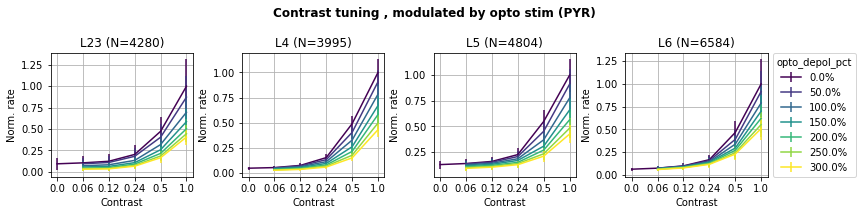

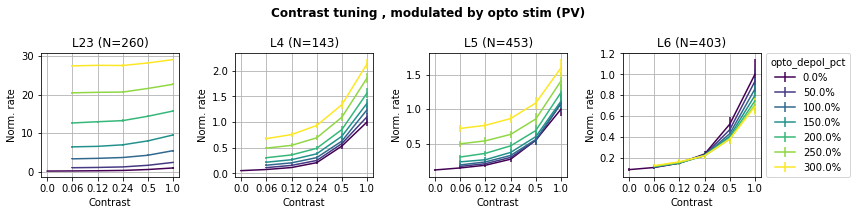

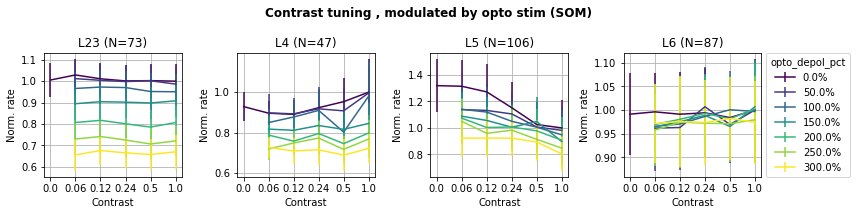

In [106]:
# Plot mean contrast tuning per layer, modulated by opto stim
for tc, bl, gids, lbl in zip([norm_tuning_curves_PYR, norm_tuning_curves_PV, norm_tuning_curves_SOM], [norm_baselines_PYR, norm_baselines_PV, norm_baselines_SOM], [gids_PYR, gids_PV, gids_SOM], ['PYR', 'PV', 'SOM']):
    plot_mean_modulated_contrast_response_function_per_layer(tc, bl, gids, circuit, contrasts, opto_depol_pct, merged_layers=[[2, 3]], save_path=save_path, save_spec=lbl, tuning_property=tuning_property, title_spec=f', modulated by opto stim ({lbl})')
    # plot_split_mean_modulated_contrast_response_function_per_layer(tc, bl, gids, circuit, contrasts, opto_depol_pct, merged_layers=[[2, 3]], save_path=save_path, save_spec=lbl, tuning_property=tuning_property, title_spec=f', modulated by opto stim ({lbl})')


### Extract effective opto intensities

- Effective (actual) opto stimulus strength for differet cells (per subclass)
- NaN if not targeted by opto stimulus

In [107]:
def get_effective_opto_intensities(sims, gids, psth_data):
    opto_strength_eff = np.full((len(gids), len(sims)), np.nan)
    for sidx in range(len(sims)):
        c = Circuit(sims.iloc[sidx])
        opto_tgt = psth_data[sidx]['opto_cfg']['props']['inject_target_names']
        opto_eff = psth_data[sidx]['opto_cfg']['props']['inject_strengths'] # Effective strength
        # Run through all opto targets
        for tgt, eff in zip(opto_tgt, opto_eff):
            if not tgt in c.cells.targets: # Empty targets won't be in list => SKIP
                continue
            opto_gids = c.cells.ids(tgt)
            # Run through GIDs and set effective value, if part of opto target GIDs
            for gidx, gid in enumerate(gids):
                if gid in opto_gids:
                    assert np.isnan(opto_strength_eff[gidx, sidx]), f'ERROR: Effective opto target strength already set (gid={gid}, gidx={gidx}, sidx={sidx})!'
                    opto_strength_eff[gidx, sidx] = eff

    return opto_strength_eff

In [108]:
# Extract effective PYR opto stim strengths...
# opto_strength_eff_PYR = get_effective_opto_intensities(sims, gids_PYR, psth_data_PYR)
# np.savez(os.path.join(save_path, 'opto_strength_eff_PYR.npz'), opto_strength_eff_PYR=opto_strength_eff_PYR, opto_depol_pct=opto_depol_pct, gids_PYR=gids_PYR)

# ...OR load from file
opto_strength_data = np.load(os.path.join(save_path, 'opto_strength_eff_PYR.npz'), allow_pickle=True)
opto_strength_eff_PYR = opto_strength_data['opto_strength_eff_PYR']
del opto_strength_data

In [109]:
# Extract effective PV opto stim strengths...
# opto_strength_eff_PV = get_effective_opto_intensities(sims, gids_PV, psth_data_PV)
# np.savez(os.path.join(save_path, 'opto_strength_eff_PV.npz'), opto_strength_eff_PV=opto_strength_eff_PV, opto_depol_pct=opto_depol_pct, gids_PV=gids_PV)

# ...OR load from file
opto_strength_data = np.load(os.path.join(save_path, 'opto_strength_eff_PV.npz'), allow_pickle=True)
opto_strength_eff_PV = opto_strength_data['opto_strength_eff_PV']
del opto_strength_data

In [110]:
# Extract effective SOM opto stim strengths...
# opto_strength_eff_SOM = get_effective_opto_intensities(sims, gids_SOM, psth_data_SOM)
# np.savez(os.path.join(save_path, 'opto_strength_eff_SOM.npz'), opto_strength_eff_SOM=opto_strength_eff_SOM, opto_depol_pct=opto_depol_pct, gids_SOM=gids_SOM)

# ...OR load from file
opto_strength_data = np.load(os.path.join(save_path, 'opto_strength_eff_SOM.npz'), allow_pickle=True)
opto_strength_eff_SOM = opto_strength_data['opto_strength_eff_SOM']
del opto_strength_data

### Load neuron info
- Neuron info (m-type, layer, synapse class, ...) per subclass
- Cortical depth (voxel-based) per subclass

In [111]:
nrn_props = ['mtype', 'layer', 'synapse_class']
neuron_info_PYR = circuit.cells.get(gids_PYR, properties=nrn_props)
neuron_info_PV = circuit.cells.get(gids_PV, properties=nrn_props)
neuron_info_SOM = circuit.cells.get(gids_SOM, properties=nrn_props)

# Add depth values (voxel-based; the ones that have been used for generating th opto stimulus)
depth_file = psth_data_PYR[0]['opto_cfg']['cfg']['opto_depth_map_file']
assert depth_file == psth_data_PYR[0]['opto_cfg']['cfg']['opto_depth_map_file'] == psth_data_PV[0]['opto_cfg']['cfg']['opto_depth_map_file'] == psth_data_SOM[0]['opto_cfg']['cfg']['opto_depth_map_file'], 'ERROR: Depth map mismatch!'
depth_map = voxcell.VoxelData.load_nrrd(depth_file)
print(f'INFO: Loading depth values from "{depth_file}"')
nrn_depths_PYR = depth_map.lookup(circuit.cells.positions(gids_PYR).to_numpy()).astype(float)
nrn_depths_PV = depth_map.lookup(circuit.cells.positions(gids_PV).to_numpy()).astype(float)
nrn_depths_SOM = depth_map.lookup(circuit.cells.positions(gids_SOM).to_numpy()).astype(float)
assert not np.any(nrn_depths_PYR == -1.0) and not np.any(nrn_depths_PV == -1.0) and not np.any(nrn_depths_SOM == -1.0), 'ERROR: Depth value(s) missing!'

neuron_info_PYR['depth'] = nrn_depths_PYR
neuron_info_PV['depth'] = nrn_depths_PV
neuron_info_SOM['depth'] = nrn_depths_SOM

INFO: Loading depth values from "/gpfs/bbp.cscs.ch/project/proj83/home/bolanos/BB_Rat_SSCX_flatmap_v2_depths.nrrd"


In [112]:
# [ALTERNATIVE]
# # Load from neuron info table (super-sampled depth values)
# neuron_info_file = '/gpfs/bbp.cscs.ch/project/proj102/scratch/SSCX_BioM/matrices/neuron_info__NoLZ4__.feather' # [Use __NoLZ4__ version to prevent "ArrowNotImplementedError: Support for codec 'lz4' not built"]
# neuron_info = pd.read_feather(neuron_info_file)
# neuron_info.index = neuron_info['gid']
# neuron_info.drop('gid', axis=1, inplace=True)

# # Extract subtypes in sim target (hex0)
# neuron_info_PYR = neuron_info.loc[gids_PYR]
# neuron_info_PV = neuron_info.loc[gids_PV]
# neuron_info_SOM = neuron_info.loc[gids_SOM]

In [113]:
# Plot depth vs. opto strength
def plot_depth_gradient(depths, opto_strength_eff, opto_depol_pct, show_bars=False, save_path=None, save_spec=None):
    if save_spec is None:
        save_spec = ''
    if len(save_spec) > 0:
        save_spec_fn = f'_{save_spec}'
        save_spec_tl = f' ({save_spec})'

    depol_colors = plt.cm.viridis(np.linspace(0, 1, len(opto_depol_pct)))
    plt.figure()
    if show_bars:
        for sidx in np.arange(len(opto_depol_pct))[::-1]:
            pct = opto_depol_pct[sidx]
            eff_val = np.unique(opto_strength_eff[:, sidx])
            d_ranges = []
            for v in eff_val:
                d_vals = depths[opto_strength_eff[:, sidx] == v]
                d_ranges.append(np.max(d_vals))
                d_ranges.append(np.min(d_vals))
            bins = [d_ranges[0]] + [np.mean(d_ranges[i : i + 2]) for i in range(1, len(d_ranges) - 1, 2)] + [d_ranges[-1]]
            for bidx in range(len(bins) - 1):
                plt.barh(np.mean(bins[bidx : bidx + 2]), eff_val[bidx], height=np.diff(bins[bidx : bidx + 2]), color=depol_colors[sidx, :], alpha=0.25) #, label=f'{pct}%' if bidx == 0 else None)
    for sidx, pct in enumerate(opto_depol_pct):
        plt.plot(opto_strength_eff[:, sidx], depths, '.', color=depol_colors[sidx, :], label=f'{pct}%')

    # plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.xlabel('Effective depolarization (%)')
    plt.ylabel('Depth (um)')
    plt.title(f'Depth gradient of optogenetic depolarization{save_spec_tl}', fontweight='bold')
    plt.legend(title='opto_depol_pct')
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f'opto_depth_gradient{save_spec_fn}.png'), dpi=300)
    plt.show()

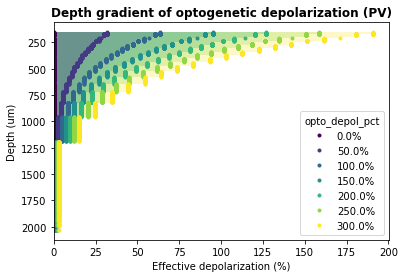

In [114]:
plot_depth_gradient(neuron_info_PV['depth'], opto_strength_eff_PV, opto_depol_pct, show_bars=True, save_path=save_path, save_spec='PV')

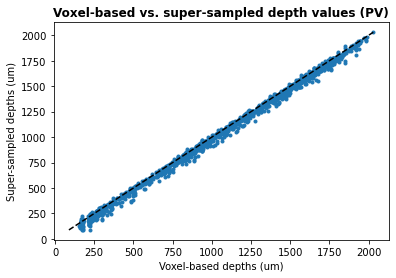

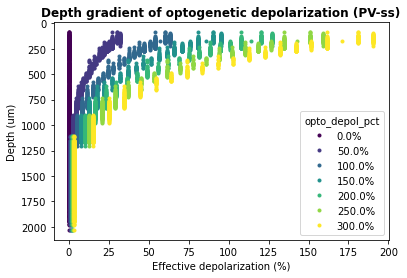

In [115]:
# Compare with super-samples depth values (PV)
nrn_info_tmp_file = '/gpfs/bbp.cscs.ch/project/proj102/scratch/SSCX_BioM/matrices/neuron_info__NoLZ4__.feather' # [Use __NoLZ4__ version to prevent "ArrowNotImplementedError: Support for codec 'lz4' not built"]
nrn_info_tmp = pd.read_feather(nrn_info_tmp_file)
nrn_info_tmp.index = nrn_info_tmp['gid']
nrn_depth_ss_PV = nrn_info_tmp['depth'].loc[gids_PV]

plt.figure()
plt.plot(neuron_info_PV['depth'], nrn_depth_ss_PV, '.')
plt.plot([min(nrn_depth_ss_PV), max(nrn_depth_ss_PV)], [min(nrn_depth_ss_PV), max(nrn_depth_ss_PV)], '--k')
plt.xlabel('Voxel-based depths (um)')
plt.ylabel('Super-sampled depths (um)')
plt.title('Voxel-based vs. super-sampled depth values (PV)', fontweight='bold')
plt.savefig(os.path.join(save_path, f'opto_depth_comparison_PV.png'), dpi=300)
plt.show()

plot_depth_gradient(nrn_depth_ss_PV, opto_strength_eff_PV, opto_depol_pct, show_bars=False, save_path=save_path, save_spec='PV-ss')

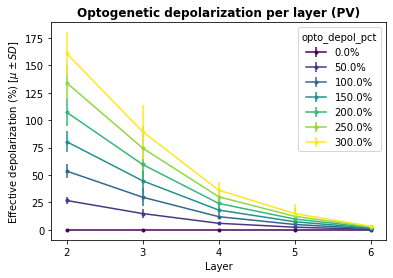

In [116]:
# Effective depolarization per layer
layers = np.unique(neuron_info_PV['layer'])
depol_colors = plt.cm.viridis(np.linspace(0, 1, len(opto_depol_pct)))
plt.figure()
# for lidx, lay in enumerate(layers):
#     for sidx, pct in enumerate(opto_depol_pct):
#         lay_sel = neuron_info_PV['layer'] == lay
#         plt.plot(np.full(np.sum(lay_sel), lay), opto_strength_eff_PV[lay_sel, sidx], '.', color=depol_colors[sidx, :], label=f'{pct}%' if lidx==0 else None)

for sidx, pct in enumerate(opto_depol_pct):
    lay_means = [np.mean(opto_strength_eff_PV[neuron_info_PV['layer'] == lay, sidx]) for lay in layers]
    lay_stds = [np.std(opto_strength_eff_PV[neuron_info_PV['layer'] == lay, sidx]) for lay in layers]
    # plt.plot(layers, lay_means, '.-', color=depol_colors[sidx, :], label=f'{pct}%')
    plt.errorbar(layers, lay_means, yerr=lay_stds, fmt='.-', color=depol_colors[sidx, :], label=f'{pct}%')

plt.xticks(layers)
plt.xlabel('Layer')
plt.ylabel('Effective depolarization (%) [$\mu \pm SD$]')
plt.title('Optogenetic depolarization per layer (PV)', fontweight='bold')
plt.legend(title='opto_depol_pct')
plt.savefig(os.path.join(save_path, f'opto_depth_per_layer_PV.png'), dpi=300)
plt.show()

### Sigmoidal fit to normalized tuning curves

In [117]:
# Sigmoidal function
R = lambda c, m, n, Rmax, c50: (Rmax * c**n) / (c**n + c50**n) + m # Sigmoidal response function R(c) [Shapiro et al. 2021]
num_fit_params = R.__code__.co_argcount - 1
fit_param_names = R.__code__.co_varnames[1:]
# R(c) ... Amplitude of the evoked response at contrast c
# m ...... Baseline response to minimum contrast
# n ...... Exponent that determines the steepness of the curve
# Rmax ... Maximum elevation in response above the baseline
# c50 .... Contrast that generates a response elevation of half Rmax

In [118]:
# Sigmoidal fit to normalized tuning curve [parallel processing]
import multiprocessing as mp

def fit_fct(r_data):
    """ Sigmoidal model fitting function for looping over data sets.
        Requires: R ... Global definition of sigmoidal contrast tuning function R(c, m, n, Rmax, c50) [Shapiro et al. 2021]
                  num_fit_params ... Global definition of number of fitting parameters
                  contrasts ... Global definition of #contrasts contrast levels
    """
    try:
        p_opt, _ = curve_fit(R, contrasts, r_data, p0=[0.0, 2.0, 1.0, 0.25], bounds=(0, [np.inf, np.inf, np.inf, 1.0]), maxfev=100000)
        r_sq = r2_score(r_data, R(contrasts, *p_opt)) # Goodness of fit
    except BaseException as e:
        p_opt = np.full(num_fit_params, np.nan)
        r_sq = np.nan
    return [p_opt, r_sq]

def sigmoidal_tuning_fits(tuning_data, workers=1):
    """Sigmoidal parameter fitting to (normalized) tuning curve data.
       tuning_data ... List of <#GIDs x #contrasts> arrays for different simulation conditions (e.g., opto stim levels)
       Returns: List of same length as tuning_data of <#GIDs x #fit_params> arrays (fit_params: m, n, Rmax, c50)
                List of same length as tuning_data of <#GIDs x 1> arrays containing goodness-of-fit estimates (R2 score)
    """
    if workers > 1:
        pool = mp.Pool(workers)
    else:
        pool = None

    opt_fit_params = []
    goodness_of_fits = []
    for data_set in tqdm.tqdm(tuning_data): # Loop over simulation conditions
        if pool is None:
            res = list(map(fit_fct, data_set))
        else:
            res = pool.map(fit_fct, data_set)
        p_opt = np.array([r[0] for r in res])
        r_sq = np.array([r[1] for r in res])
        opt_fit_params.append(p_opt)
        goodness_of_fits.append(r_sq)

    if pool is not None:
        pool.close()

#     num_fit_params = R.__code__.co_argcount - 1
#     opt_fit_params = []
#     goodness_of_fits = []
#     with tqdm.tqdm(total=len(tuning_data), position=0, bar_format='{l_bar}{bar}| {n:.2f}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]') as pbar:
#         for data_set in tuning_data: # Loop over simulation conditions
#             p_opt = np.full((data_set.shape[0], num_fit_params), np.nan)
#             r_sq = np.full(data_set.shape[0], np.nan)
#             for n, r_data in enumerate(data_set): # Loop over GIDs
#                 if np.all(np.isfinite(r_data)):
#                     p_opt[n, :], _ = curve_fit(R, contrasts, r_data, p0=[0.0, 2.0, 1.0, 0.25], bounds=(0, [np.inf, np.inf, np.inf, 1.0]), maxfev=100000)
#                     r_sq[n] = r2_score(r_data, R(contrasts, *p_opt[n, :])) # Goodness of fit
#                 pbar.update(1.0 / data_set.shape[0])
#             opt_fit_params.append(p_opt)
#             goodness_of_fits.append(r_sq)

    return opt_fit_params, goodness_of_fits

In [119]:
# Compute opt PYR tuning fit parameters...
# opt_fit_params_PYR, goodness_of_fits_PYR = sigmoidal_tuning_fits([norm_tuning_curves_PYR[sidx]['mean'][:, len(contrasts):] for sidx in range(num_sims)], workers=64)
# np.savez(os.path.join(save_path, 'opt_fit_params_PYR.npz'), opt_fit_params_PYR=opt_fit_params_PYR, goodness_of_fits_PYR=goodness_of_fits_PYR, gids_PYR=gids_PYR)

# ...OR load from file
fit_data = np.load(os.path.join(save_path, 'opt_fit_params_PYR.npz'), allow_pickle=True)
opt_fit_params_PYR = list(fit_data['opt_fit_params_PYR'])
goodness_of_fits_PYR = list(fit_data['goodness_of_fits_PYR'])
del fit_data

In [120]:
# Compute opt PV tuning fit parameters...
# opt_fit_params_PV, goodness_of_fits_PV = sigmoidal_tuning_fits([norm_tuning_curves_PV[sidx]['mean'][:, len(contrasts):] for sidx in range(num_sims)], workers=64)
# np.savez(os.path.join(save_path, 'opt_fit_params_PV.npz'), opt_fit_params_PV=opt_fit_params_PV, goodness_of_fits_PV=goodness_of_fits_PV, gids_PV=gids_PV)

# ...OR load from file
fit_data = np.load(os.path.join(save_path, 'opt_fit_params_PV.npz'), allow_pickle=True)
opt_fit_params_PV = list(fit_data['opt_fit_params_PV'])
goodness_of_fits_PV = list(fit_data['goodness_of_fits_PV'])
del fit_data

In [121]:
# Compute opt SOM tuning fit parameters...
# opt_fit_params_SOM, goodness_of_fits_SOM = sigmoidal_tuning_fits([norm_tuning_curves_SOM[sidx]['mean'][:, len(contrasts):] for sidx in range(num_sims)], workers=64)
# np.savez(os.path.join(save_path, 'opt_fit_params_SOM.npz'), opt_fit_params_SOM=opt_fit_params_SOM, goodness_of_fits_SOM=goodness_of_fits_SOM, gids_SOM=gids_SOM)

# ...OR load from file
fit_data = np.load(os.path.join(save_path, 'opt_fit_params_SOM.npz'), allow_pickle=True)
opt_fit_params_SOM = list(fit_data['opt_fit_params_SOM'])
goodness_of_fits_SOM = list(fit_data['goodness_of_fits_SOM'])
del fit_data

### Check tuning behavior
- Mean firing rate above threshold (0.5 Hz)?
- Mean norm. tuning (striclty) monotonously increasing?
- Mean norm. tuning above baseline?
- Goodness of fits?
- Unusual range of fitting parameters?

In [122]:
# def check_sparse_firing(tuning_rates, rate_th=0.5, with_opto=False):
#     """ Check if cells are sparsely firing below a given threshold (in Hz) under various sim conditions. """
#     num_gids = tuning_rates.shape[0]
#     num_patterns = tuning_rates.shape[1] >> 1
#     pidx = np.arange(num_patterns) # Pattern indices w/o opto stim (i.e., starting at 0)
#     if with_opto:
#         pidx = pidx + num_patterns # Pattern indices with opto stim (i.e., starting at <num_patterns>)

#     low_firing = tuning_rates[:, pidx] < rate_th

#     return low_firing


def check_robust_firing(tuning_curves, rate_th=0.5, with_opto=False):
    """ Check if cells are robustly firing with at least the given threshold firing rate (in Hz) for all contrasts. """
    num_sims = len(tuning_curves)
    num_gids = tuning_curves[0]['mean'].shape[0]

    robust_firing = np.full((num_gids, num_sims), False)

    num_patterns = tuning_curves[0]['mean'].shape[1] >> 1
    pidx = np.arange(num_patterns) # Pattern indices w/o opto stim (i.e., starting at 0)
    if with_opto:
        pidx = pidx + num_patterns # Pattern indices with opto stim (i.e., starting at <num_patterns>)

    for sidx in range(num_sims):
        robust_firing[:, sidx] = np.all(tuning_curves[sidx]['mean'][:, pidx] >= rate_th, axis=1)

    return robust_firing


def check_tuning_behavior(norm_tuning_curves, norm_baselines, with_opto=False):
    """ Check if single-cell normalized tuning curves are (strictly) monotonic increasing and above baseline. """
    num_sims = len(norm_tuning_curves)
    num_gids = norm_tuning_curves[0]['mean'].shape[0]

    monot_inc = np.full((num_gids, num_sims), False)
    strict_monot_inc = np.full((num_gids, num_sims), False)
    above_baseline = np.full((num_gids, num_sims), False)
    strict_above_baseline = np.full((num_gids, num_sims), False)

    num_patterns = norm_tuning_curves[0]['mean'].shape[1] >> 1
    pidx = np.arange(num_patterns) # Pattern indices w/o opto stim (i.e., starting at 0)
    if with_opto:
        pidx = pidx + num_patterns # Pattern indices with opto stim (i.e., starting at <num_patterns>)

    for sidx in range(num_sims):
        tc = norm_tuning_curves[sidx]['mean'][:, pidx]
        bl = np.mean(norm_baselines[sidx]['mean'][:, pidx], 1, keepdims=True)
        monot_inc[:, sidx] = np.all(np.diff(tc, axis=1) >= 0, axis=1)
        strict_monot_inc[:, sidx] = np.all(np.diff(tc, axis=1) > 0, axis=1)
        above_baseline[:, sidx] = np.all(tc >= bl, axis=1)
        strict_above_baseline[:, sidx] = np.all(tc > bl, axis=1)

    return monot_inc, strict_monot_inc, above_baseline, strict_above_baseline


def check_constraint(opt_fit_params, fit_param_names, constr_dict):
    """ Checks constraints on different fitting parameters.
        Constraints are specified by dictionaries containing an
        evaluation function ('fct') and a threshold ('th'), e.g.
        constr_dict = {'n': {'th': 10, 'fct': np.less}}
    """
    num_sims = len(opt_fit_params)
    num_gids = opt_fit_params[0].shape[0]
    num_params = len(fit_param_names)
    assert np.all([opt_fit_params[i].shape[1] == num_params for i in range(num_sims)]), 'ERROR: Fitting parameter mismatch!'
    assert np.all(np.isin(list(constr_dict.keys()), fit_param_names)), 'ERROR: Parameter names mismatch!'

    constr_mat = np.full((num_gids, num_sims), True)
    for pname, pconstr in constr_dict.items():
        pidx = np.where(np.array(fit_param_names) == pname)[0][0]
        for sidx in range(num_sims):
            constr_mat[:, sidx] = np.logical_and(constr_mat[:, sidx], pconstr['fct'](opt_fit_params[sidx][:, pidx], pconstr['th']))

    return constr_mat


def print_fraction(name, cond):
    """ Prints fraction (absolute counts & percent) of the given condition being True. """
    return f'{name} {np.sum(cond)}/{len(cond)} ({100 * np.sum(cond) / len(cond):.2f}%)'


In [123]:
# Check firing behavior
rate_th = 0.5 # (hz) Rate threshold 0.5Hz from Pedreira et al. 2012 "How many neurons can we see with current spike sorting algorithms?"
robust_firing_PYR = check_robust_firing(tuning_curves_PYR, rate_th=rate_th, with_opto=True)
robust_firing_PV = check_robust_firing(tuning_curves_PV, rate_th=rate_th, with_opto=True)
robust_firing_SOM = check_robust_firing(tuning_curves_SOM, rate_th=rate_th, with_opto=True)
robust_firing_PYR = np.all(robust_firing_PYR, 1) # Robust firing under all opto stim conditinos
robust_firing_PV = np.all(robust_firing_PV, 1) # Robust firing under all opto stim conditinos
robust_firing_SOM = np.all(robust_firing_SOM, 1) # Robust firing under all opto stim conditinos

print(f'Robust firing above {rate_th} Hz under all conditions:\n  {print_fraction("PYR", robust_firing_PYR)}, {print_fraction("PV", robust_firing_PV)}, {print_fraction("SOM", robust_firing_SOM)}')

# Check tuning behavior
monot_inc_PYR, strict_monot_inc_PYR, above_baseline_PYR, strict_above_baseline_PYR = check_tuning_behavior(norm_tuning_curves_PYR, norm_baselines_PYR, with_opto=True)
monot_inc_PV, strict_monot_inc_PV, above_baseline_PV, strict_above_baseline_PV = check_tuning_behavior(norm_tuning_curves_PV, norm_baselines_PV, with_opto=True)
monot_inc_SOM, strict_monot_inc_SOM, above_baseline_SOM, strict_above_baseline_SOM = check_tuning_behavior(norm_tuning_curves_SOM, norm_baselines_SOM, with_opto=True)
# robust_tuning_PYR = strict_monot_inc_PYR[:, 0] # Robust tuning under baseline conditions
# robust_tuning_PV = strict_monot_inc_PV[:, 0] # Robust tuning under baseline conditions
# robust_tuning_SOM = strict_monot_inc_SOM[:, 0] # Robust tuning under baseline stim conditions
robust_tuning_PYR = np.all(strict_monot_inc_PYR, 1) # Robust tuning under all opto stim conditions
robust_tuning_PV = np.all(strict_monot_inc_PV, 1) # Robust tuning under all opto stim conditions
robust_tuning_SOM = np.all(strict_monot_inc_SOM, 1) # Robust tuning under all opto stim conditions
print(f'Robust (strictly monotonic) tuning under all conditions:\n  {print_fraction("PYR", robust_tuning_PYR)}, {print_fraction("PV", robust_tuning_PV)}, {print_fraction("SOM", robust_tuning_SOM)}')

# # Check goodness of tuning curve parameter fits
# gof_th = 0.9 # Goodness-of-fit selection threshold
# robust_fitting_PYR = np.all(np.array(goodness_of_fits_PYR) >= gof_th, 0)
# robust_fitting_PV = np.all(np.array(goodness_of_fits_PV) >= gof_th, 0)
# robust_fitting_SOM = np.all(np.array(goodness_of_fits_SOM) >= gof_th, 0)
# print(f'Robust tuning parameter fit (goodness-of-fit >= {gof_th}) under all conditions:\n  {print_fraction("PYR", robust_fitting_PYR)}, {print_fraction("PV", robust_fitting_PV)}, {print_fraction("SOM", robust_fitting_SOM)}')

# # Additional constraints on fitting parameter values
# fit_param_sel_dict = {'n': {'th': 10, 'fct': np.less}} #'c50': {'th': 0.9, 'fct': np.less}
# fit_param_sel_str = ', '.join([f'{k} {v["fct"].__name__} than {v["th"]}' for k, v in fit_param_sel_dict.items()])
# fit_param_constr_PYR = np.all(check_constraint(opt_fit_params_PYR, fit_param_names, fit_param_sel_dict), 1)
# fit_param_constr_PV = np.all(check_constraint(opt_fit_params_PV, fit_param_names, fit_param_sel_dict), 1)
# fit_param_constr_SOM = np.all(check_constraint(opt_fit_params_SOM, fit_param_names, fit_param_sel_dict), 1)
# print(f'Constrained fitting parameter ranges ({fit_param_sel_str}) under all conditions:\n  {print_fraction("PYR", fit_param_constr_PYR)}, {print_fraction("PV", fit_param_constr_PV)}, {print_fraction("SOM", fit_param_constr_SOM)}')

# Select "robust" cells for all further analysis
robust_cell_idx_PYR = np.logical_and(robust_firing_PYR, robust_tuning_PYR)
robust_cell_idx_PV = np.logical_and(robust_firing_PV, robust_tuning_PV)
robust_cell_idx_SOM = np.logical_and(robust_firing_SOM, robust_tuning_SOM)
print(f'CELL SELECTION - Robust firing & tuning under all conditions:\n  {print_fraction("PYR", robust_cell_idx_PYR)}, {print_fraction("PV", robust_cell_idx_PV)}, {print_fraction("SOM", robust_cell_idx_SOM)}')
np.savez(os.path.join(save_path, 'robust_cells.npz'), gids_PYR=gids_PYR, gids_PV=gids_PV, gids_SOM=gids_SOM,
         robust_cell_idx_PYR=robust_cell_idx_PYR, robust_firing_PYR=robust_firing_PYR, robust_tuning_PYR=robust_tuning_PYR,
         robust_cell_idx_PV=robust_cell_idx_PV, robust_firing_PV=robust_firing_PV, robust_tuning_PV=robust_tuning_PV,
         robust_cell_idx_SOM=robust_cell_idx_SOM, robust_firing_SOM=robust_firing_SOM, robust_tuning_SOM=robust_tuning_SOM)

### [ALTERNATIVES] ###
# robust_cell_idx_PYR = robust_firing_PYR
# robust_cell_idx_PV = robust_firing_PV
# robust_cell_idx_SOM = robust_firing_SOM
# print(f'CELL SELECTION - Robust firing under all conditions:\n  {print_fraction("PYR", robust_cell_idx_PYR)}, {print_fraction("PV", robust_cell_idx_PV)}, {print_fraction("SOM", robust_cell_idx_SOM)}')
# robust_cell_idx_PYR = np.logical_and(np.logical_and(robust_firing_PYR, robust_fitting_PYR), fit_param_constr_PYR)
# robust_cell_idx_PV = np.logical_and(np.logical_and(robust_firing_PV, robust_fitting_PV), fit_param_constr_PV)
# robust_cell_idx_SOM = np.logical_and(np.logical_and(robust_firing_SOM, robust_fitting_SOM), fit_param_constr_SOM)
# print(f'\nCELL SELECTION - Robust firing & fitting & constrained tuning fit parameters under all conditions:\n  {print_fraction("PYR", robust_cell_idx_PYR)}, {print_fraction("PV", robust_cell_idx_PV)}, {print_fraction("SOM", robust_cell_idx_SOM)}')


Robust firing above 0.5 Hz under all conditions:
  PYR 1587/26373 (6.02%), PV 476/1654 (28.78%), SOM 240/822 (29.20%)
Robust (strictly monotonic) tuning under all conditions:
  PYR 1020/26373 (3.87%), PV 358/1654 (21.64%), SOM 0/822 (0.00%)
CELL SELECTION - Robust firing & tuning under all conditions:
  PYR 228/26373 (0.86%), PV 259/1654 (15.66%), SOM 0/822 (0.00%)


PYR: size=1596 amin=0.866 amax=1.000 mean=0.990 std=0.012 median=0.995
PV: size=1813 amin=0.931 amax=1.000 mean=0.995 std=0.008 median=0.997
SOM: size=nan amin=nan amax=nan mean=nan std=nan median=nan
ALL: size=3409 amin=0.866 amax=1.000 mean=0.992 std=0.010 median=0.997


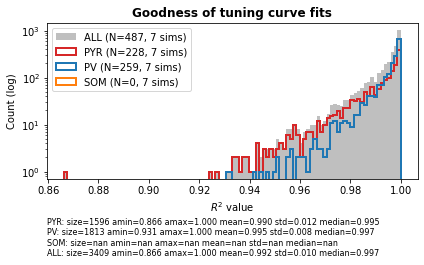

In [124]:
# Check goodness of fits
def print_stats(name, data):
    """ Print data statistics (min/max/mean/std/median). """
    fcts = [np.size, np.min, np.max, np.mean, np.std, np.median]
    is_float = [False, True, True, True, True, True]
    stat_str = f'{name}:'
    for f, isf in zip(fcts, is_float):
        if np.size(data) == 0:
            val = np.nan
        else:
            val = f(data)
        if isf:
            stat_str = f'{stat_str} {f.__name__}={val:.3f}'
        else:
            stat_str = f'{stat_str} {f.__name__}={val:.0f}'
    return stat_str

goodness_of_fits_robust_PYR = np.array(goodness_of_fits_PYR)[:, robust_cell_idx_PYR]
goodness_of_fits_robust_PV = np.array(goodness_of_fits_PV)[:, robust_cell_idx_PV]
goodness_of_fits_robust_SOM = np.array(goodness_of_fits_SOM)[:, robust_cell_idx_SOM]
goodness_of_fits_robust_ALL = np.hstack([goodness_of_fits_robust_PYR, goodness_of_fits_robust_PV, goodness_of_fits_robust_SOM])

print(print_stats('PYR', goodness_of_fits_robust_PYR))
print(print_stats('PV', goodness_of_fits_robust_PV))
print(print_stats('SOM', goodness_of_fits_robust_SOM))
print(print_stats('ALL', goodness_of_fits_robust_ALL))

num_bins = 100
plt.figure()
plt.hist(goodness_of_fits_robust_ALL.flatten(), bins=np.linspace(np.min(goodness_of_fits_robust_ALL), 1.0, num_bins + 1), color='k', alpha=0.25, label=f'ALL (N={np.sum(np.hstack([robust_cell_idx_PYR, robust_cell_idx_PV, robust_cell_idx_SOM]))}, {num_sims} sims)')
plt.hist(goodness_of_fits_robust_PYR.flatten(), bins=np.linspace(np.min(goodness_of_fits_robust_ALL), 1.0, num_bins + 1), color='tab:red', histtype='step', lw=2, label=f'PYR (N={np.sum(robust_cell_idx_PYR)}, {num_sims} sims)')
plt.hist(goodness_of_fits_robust_PV.flatten(), bins=np.linspace(np.min(goodness_of_fits_robust_ALL), 1.0, num_bins + 1), color='tab:blue', histtype='step', lw=2, label=f'PV (N={np.sum(robust_cell_idx_PV)}, {num_sims} sims)')
plt.hist(goodness_of_fits_robust_SOM.flatten(), bins=np.linspace(np.min(goodness_of_fits_robust_ALL), 1.0, num_bins + 1), color='tab:orange', histtype='step', lw=2, label=f'SOM (N={np.sum(robust_cell_idx_SOM)}, {num_sims} sims)')
plt.gca().set_yscale('log')
plt.xlabel('$R^2$ value')
plt.ylabel('Count (log)')
plt.title('Goodness of tuning curve fits', fontweight='bold')
plt.legend()
plt.annotate('\n'.join([print_stats('PYR', goodness_of_fits_robust_PYR), print_stats('PV', goodness_of_fits_robust_PV), print_stats('SOM', goodness_of_fits_robust_SOM), print_stats('ALL', goodness_of_fits_robust_ALL)]), [0, -0.25], xycoords='axes fraction', ha='left', va='top', fontsize=8)
plt.tight_layout()
if save_path is not None:
    plt.savefig(os.path.join(save_path, f'goodness_of_fits.png'), dpi=300)
plt.show()

### Quantification of tuning curve fits

In [125]:
# Check & remove outliers based on
#   goodness-of-fit values ... TODO
#   tuning curve shape (reflected by undesired fit params) ... TODO
#   cell firing rate (compatible with electrode recording & spike sorting, as in biol. experiment) ... TODO

# Plot opt fit params
# - Single cells
# - Single cells separated by layer/depth ... TODO
# - Single cells grouped by effective opto strength based on depth and opto pct ... TODO
# - Per-layer mean ... TODO (?)

# Clustering of opt fit params (??)
# Pre-selection of cells with sigmoidal tuning curve shape in baseline + preserving shape!!
# (i.e., Excluding outliers/special cases, like non-monotonously increasing tuning responses)

# Fit params of mean tuning curves (??)
# - Overall
# - Per-layer

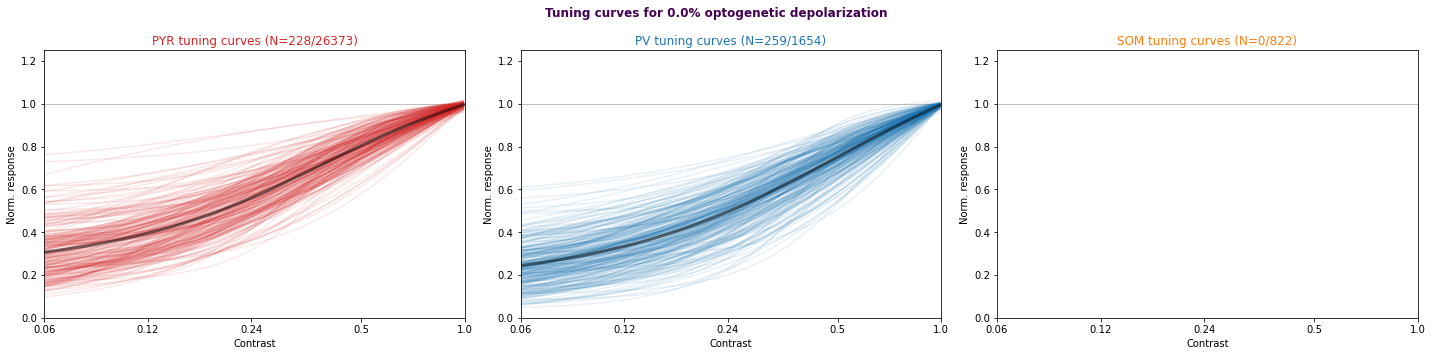

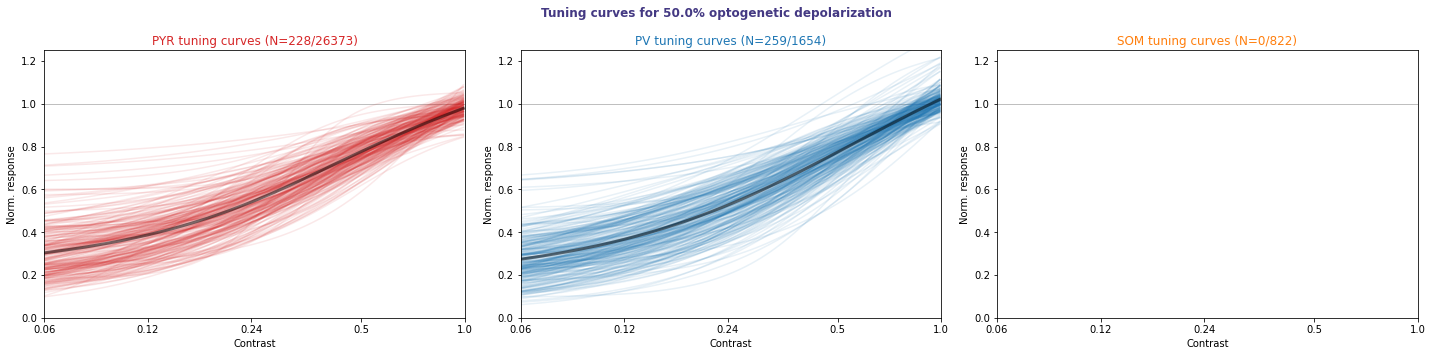

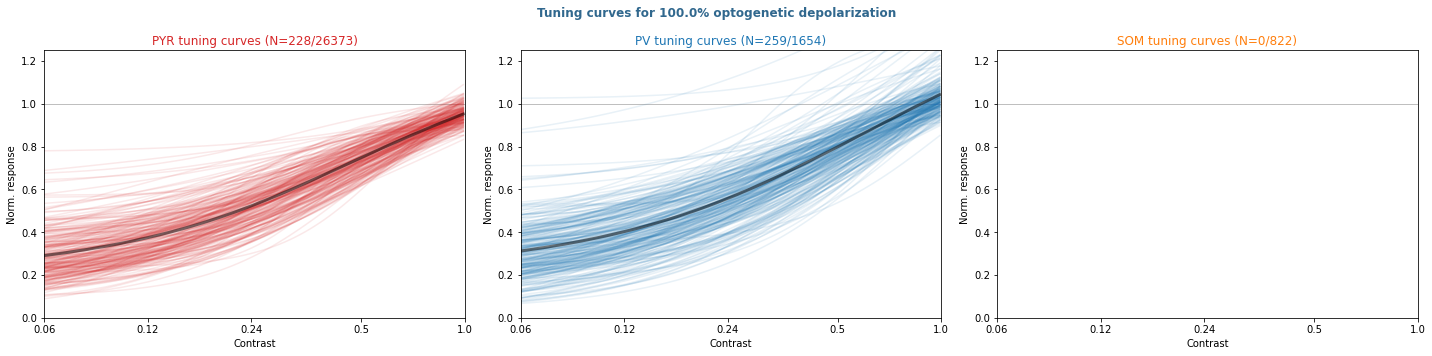

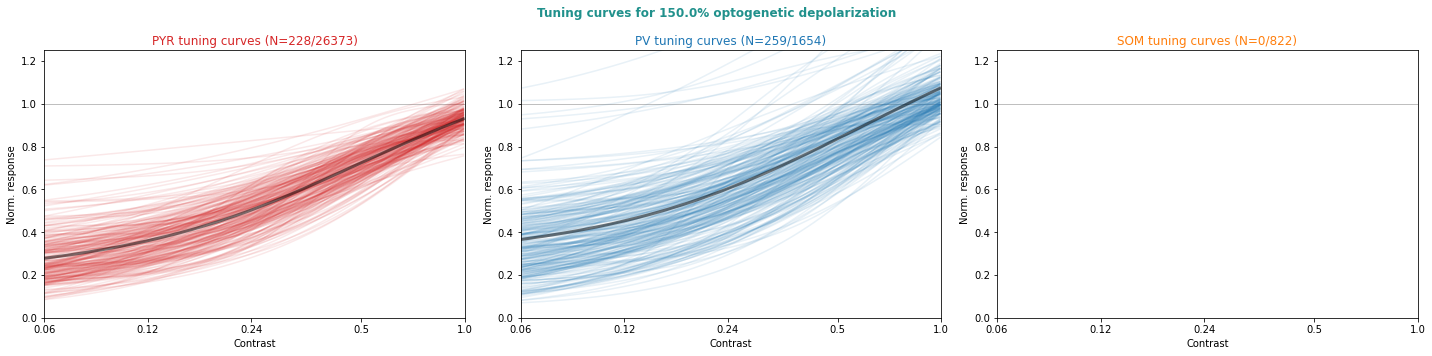

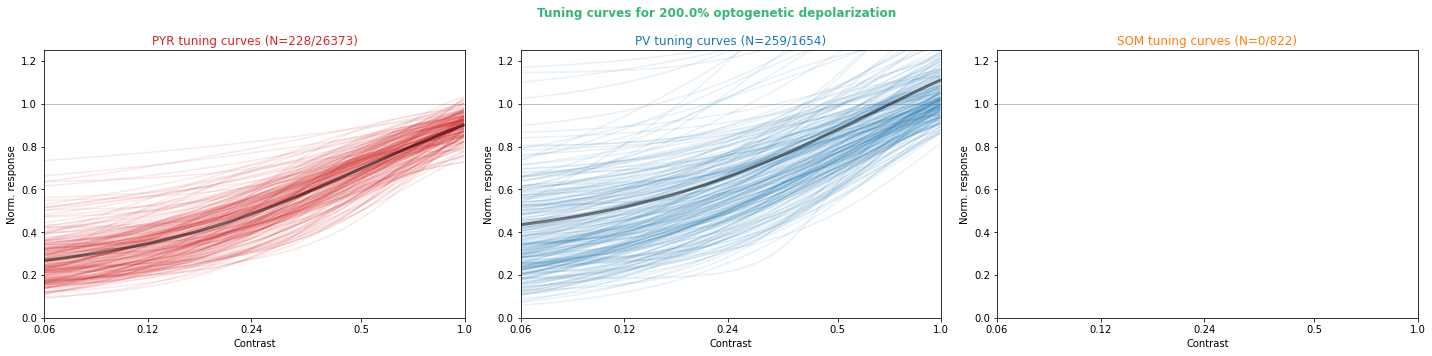

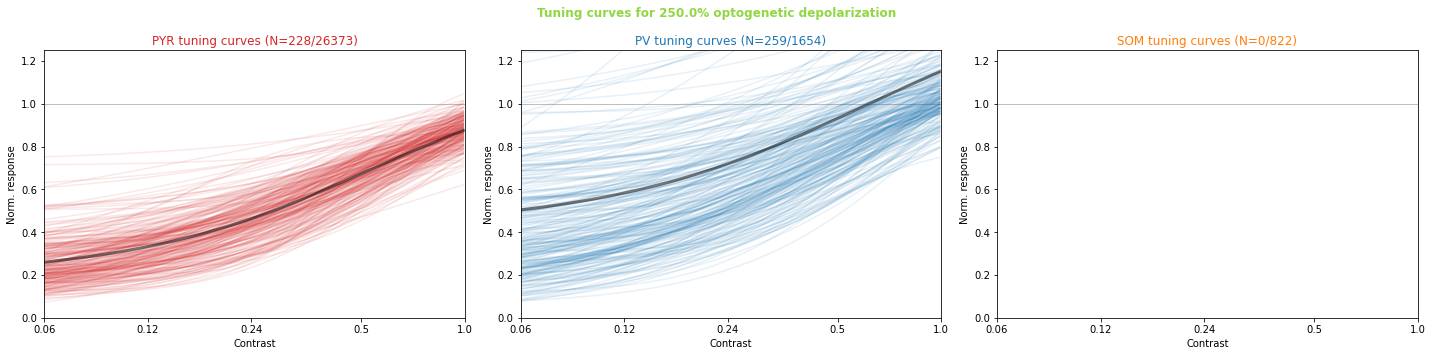

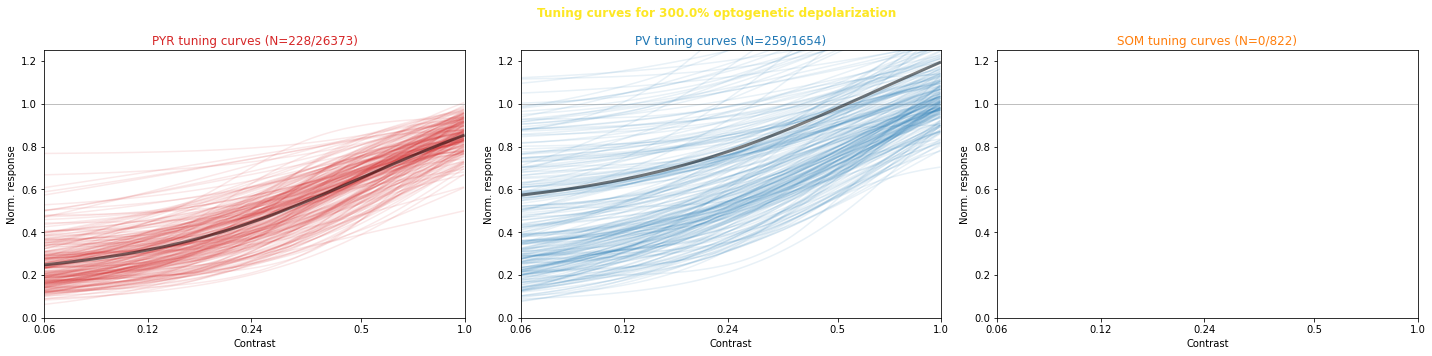

In [126]:
# Plot tuning curves
c = np.arange(min(contrasts), max(contrasts), 0.01)
level_colors = plt.cm.viridis(np.linspace(0, 1, len(opto_depol_pct)))
for opto_idx, pct in enumerate(opto_depol_pct):
    plt.figure(figsize=(20, 5))
    # for idx, (opt_fit_params, lbl, col) in enumerate(zip([opt_fit_params_PYR[opto_idx], opt_fit_params_PV[opto_idx], opt_fit_params_SOM[opto_idx]], ['PYR', 'PV', 'SOM'], ['tab:red', 'tab:blue', 'tab:orange'])): # All cells
    for idx, (opt_fit_params, sel_idx, lbl, col) in enumerate(zip([opt_fit_params_PYR[opto_idx], opt_fit_params_PV[opto_idx], opt_fit_params_SOM[opto_idx]], [robust_cell_idx_PYR, robust_cell_idx_PV, robust_cell_idx_SOM], ['PYR', 'PV', 'SOM'], ['tab:red', 'tab:blue', 'tab:orange'])): # Robust cells
        opt_fit_params = opt_fit_params[sel_idx, :]
        N = np.sum(np.all(np.isfinite(opt_fit_params), 1))
        plt.subplot(1, 3, idx + 1)
        r = np.array([R(c, *p_opt) for p_opt in opt_fit_params])
        if np.size(r) > 0:
            # plt.plot(c, r.T, color=col, alpha=100.0 / (opt_fit_params.shape[0] + 1)
            plt.plot(c, r.T, color=col, alpha=0.1)
            plt.plot(c, np.nanmean(r, 0), 'k', alpha=0.5, lw=3)
        plt.xlim([np.min(contrasts), np.max(contrasts)])
        plt.ylim([0.0, 1.25])
        plt.gca().set_xscale('log')
        plt.xticks(contrasts, labels=contrasts)
        plt.gca().minorticks_off()
        plt.hlines(1.0, xmin=np.min(plt.xlim()), xmax=np.max(plt.xlim()), color='grey', zorder=0, alpha=0.5, lw=1)
        plt.xlabel('Contrast')
        plt.ylabel('Norm. response')
        plt.title(f'{lbl} tuning curves (N={N}/{len(sel_idx)})', color=col)
    plt.suptitle(f'Tuning curves for {pct}% optogenetic depolarization', fontweight='bold', color=level_colors[opto_idx])
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f'tuning_curves_{pct}pct.png'), dpi=300)
    plt.show()

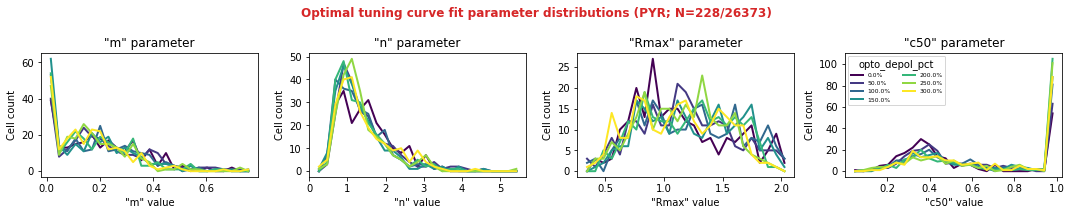

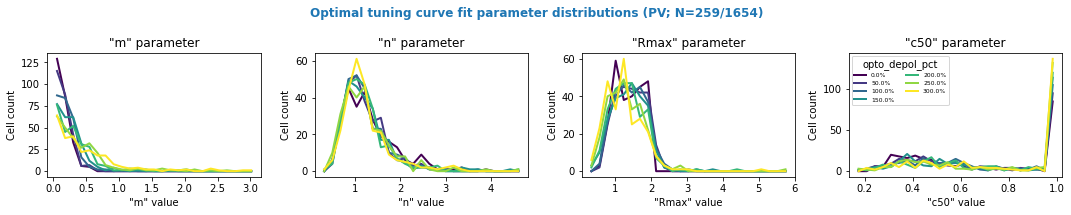

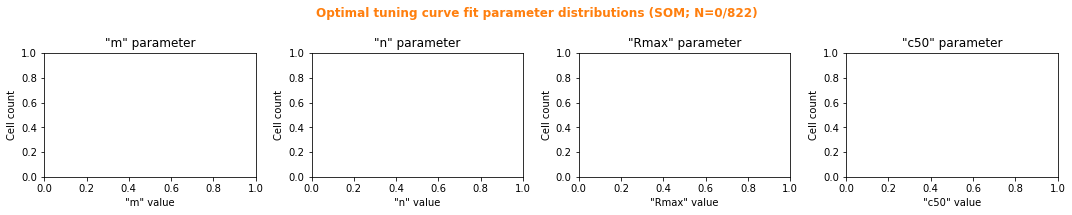

In [127]:
# Plot opt. fitting parameter distributions
num_bins = 25
for opt_fit_params, sel_idx, lbl, col in zip([opt_fit_params_PYR, opt_fit_params_PV, opt_fit_params_SOM], [robust_cell_idx_PYR, robust_cell_idx_PV, robust_cell_idx_SOM], ['PYR', 'PV', 'SOM'], ['tab:red', 'tab:blue', 'tab:orange']):
    opt_fit_params = [ofp[sel_idx, :] for ofp in opt_fit_params]
    N = np.sum(np.all(np.isfinite(opt_fit_params[0]), 1))
    plt.figure(figsize=(15, 3))
    if N > 0:
        min_vals = np.nanmin(np.nanmin(opt_fit_params, 0), 0)
        max_vals = np.nanmax(np.nanmax(opt_fit_params, 0), 0)
    for idx, p_name in enumerate(fit_param_names):
        plt.subplot(1, num_fit_params, idx + 1)
        if N > 0:
            bins = np.linspace(min_vals[idx], max_vals[idx], num_bins + 1)
            for opto_idx, pct in enumerate(opto_depol_pct):
                # plt.hist(opt_fit_params[opto_idx][:, idx], bins=bins, color=level_colors[opto_idx], histtype='bar' if opto_idx == 0 else 'step', lw=2, label=f'{pct}%')
                hist_count, _ = np.histogram(opt_fit_params[opto_idx][:, idx], bins=bins)
                plt.plot(bins[:-1] + 0.5 * np.min(np.diff(bins)), hist_count, color=level_colors[opto_idx], lw=2, label=f'{pct}%')
        plt.xlabel(f'"{p_name}" value')
        plt.ylabel('Cell count')
        plt.title(f'"{p_name}" parameter')
        # plt.yscale('log')
    if N > 0:
        plt.legend(title='opto_depol_pct', ncol=2, loc='upper left', fontsize=6)
    plt.suptitle(f'Optimal tuning curve fit parameter distributions ({lbl}; N={N}/{len(sel_idx)})', fontweight='bold', color=col)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f'fit_param_histograms_{lbl}.png'), dpi=300)
    plt.show()

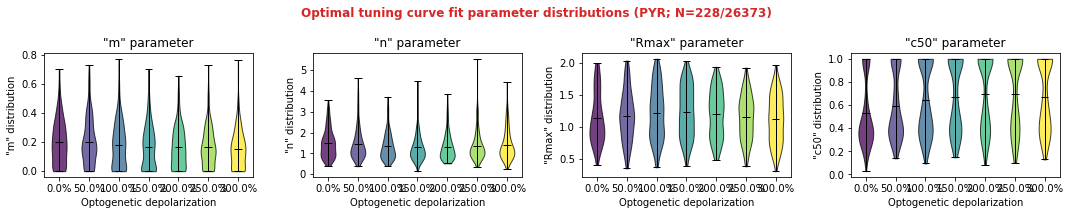

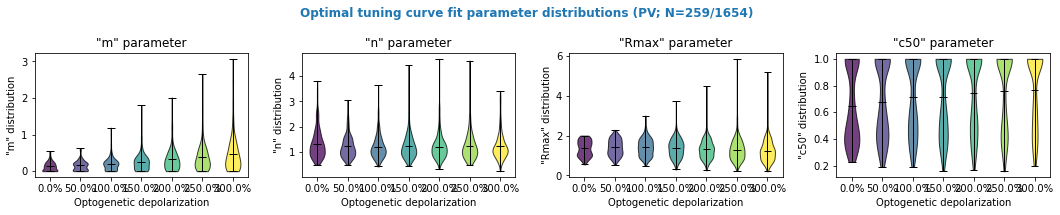

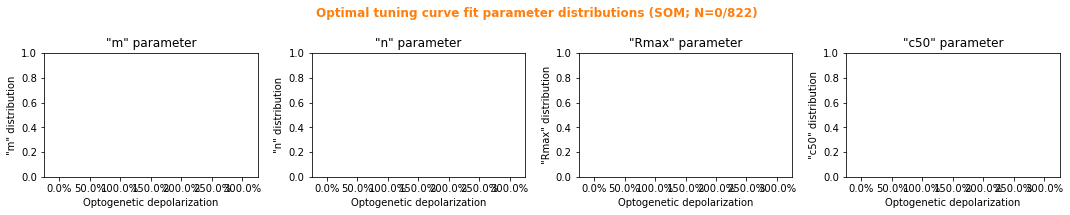

In [128]:
# Plot violinplots of opt fit param distributions for different levels of opto stim
for opt_fit_params, sel_idx, lbl, col in zip([opt_fit_params_PYR, opt_fit_params_PV, opt_fit_params_SOM], [robust_cell_idx_PYR, robust_cell_idx_PV, robust_cell_idx_SOM], ['PYR', 'PV', 'SOM'], ['tab:red', 'tab:blue', 'tab:orange']):
    opt_fit_params = [ofp[sel_idx, :] for ofp in opt_fit_params]
    N = np.sum(np.all(np.isfinite(opt_fit_params[0]), 1))
    plt.figure(figsize=(15, 3))
    for p_idx, p_name in enumerate(fit_param_names):
        plt.subplot(1, len(fit_param_names), p_idx + 1)
        if N > 0:
            p_data = [opt_fit_params[idx][np.all(np.isfinite(opt_fit_params[idx]), 1), p_idx] for idx in range(len(opto_depol_pct))]
            violin_parts = plt.violinplot(p_data, showmeans=True)
            for partname in ('cbars','cmins','cmaxes','cmeans', 'cmedians'):
                if partname in violin_parts:
                    violin_parts[partname].set_edgecolor('k')
                    violin_parts[partname].set_linewidth(1)
            for idx, pc in enumerate(violin_parts['bodies']):
                pc.set_facecolor(level_colors[idx])
                pc.set_alpha(0.75)
                pc.set_edgecolor('black')
        plt.xticks(np.arange(1, len(opto_depol_pct) + 1), labels=[f'{pct}%' for pct in opto_depol_pct])
        plt.xlim([0.5, len(opto_depol_pct) + 0.5])
        plt.xlabel('Optogenetic depolarization')
        plt.ylabel(f'"{p_name}" distribution')
        plt.title(f'"{p_name}" parameter')
    plt.suptitle(f'Optimal tuning curve fit parameter distributions ({lbl}; N={N}/{len(sel_idx)})', fontweight='bold', color=col)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f'fit_param_violins_{lbl}.png'), dpi=300)
    plt.show()

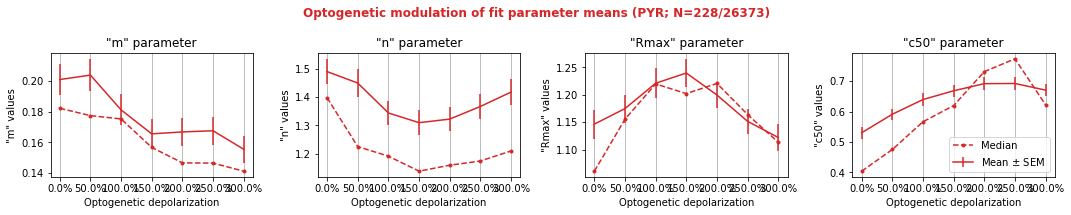

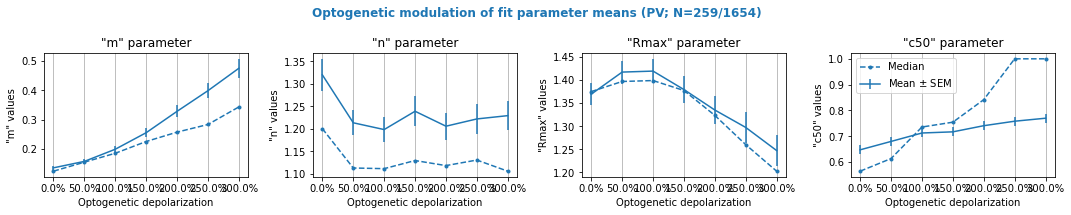

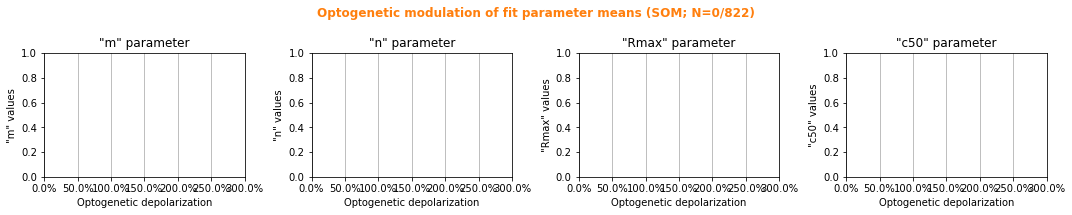

In [129]:
# Plot means of opt fit param distributions for different levels of opto stim
c = np.arange(min(contrasts), max(contrasts), 0.01)

for opt_fit_params, sel_idx, lbl, col in zip([opt_fit_params_PYR, opt_fit_params_PV, opt_fit_params_SOM], [robust_cell_idx_PYR, robust_cell_idx_PV, robust_cell_idx_SOM], ['PYR', 'PV', 'SOM'], ['tab:red', 'tab:blue', 'tab:orange']):
    opt_fit_params = [ofp[sel_idx, :] for ofp in opt_fit_params]
    N = np.sum(np.all(np.isfinite(opt_fit_params[0]), 1))
    plt.figure(figsize=(15, 3))
    for p_idx, p_name in enumerate(fit_param_names):
        plt.subplot(1, len(fit_param_names), p_idx + 1)
        if N > 0:
            mean_data = [np.nanmean(opt_fit_params[idx][:, p_idx]) for idx in range(len(opto_depol_pct))]
            median_data = [np.nanmedian(opt_fit_params[idx][:, p_idx]) for idx in range(len(opto_depol_pct))]
            std_data = [np.nanstd(opt_fit_params[idx][:, p_idx]) / np.sqrt(N) for idx in range(len(opto_depol_pct))]
            plt.errorbar(np.arange(0, len(opto_depol_pct)), mean_data, yerr=std_data, color=col, label='Mean $\pm$ SEM')
            plt.plot(np.arange(0, len(opto_depol_pct)), median_data, '.--', color=col, label='Median')
        plt.xticks(np.arange(0, len(opto_depol_pct)), labels=[f'{pct}%' for pct in opto_depol_pct])
        plt.xlabel('Optogenetic depolarization')
        plt.ylabel(f'"{p_name}" values')
        plt.title(f'"{p_name}" parameter')
        plt.grid(axis='x')
    if N > 0:
        plt.legend()
    plt.suptitle(f'Optogenetic modulation of fit parameter means ({lbl}; N={N}/{len(sel_idx)})', fontweight='bold', color=col)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f'fit_param_means_{lbl}.png'), dpi=300)
    plt.show()

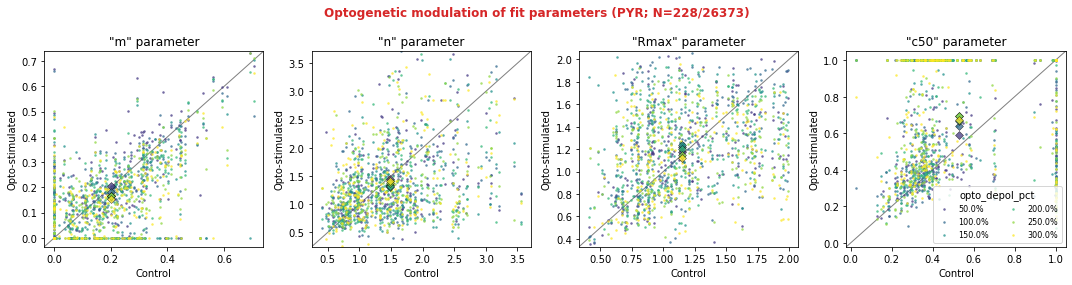

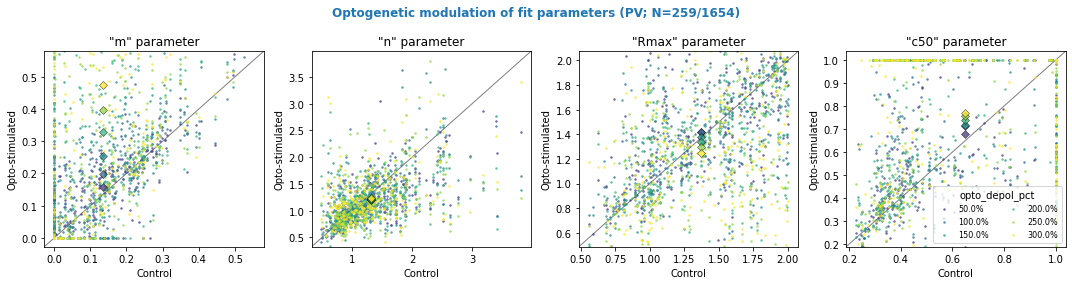

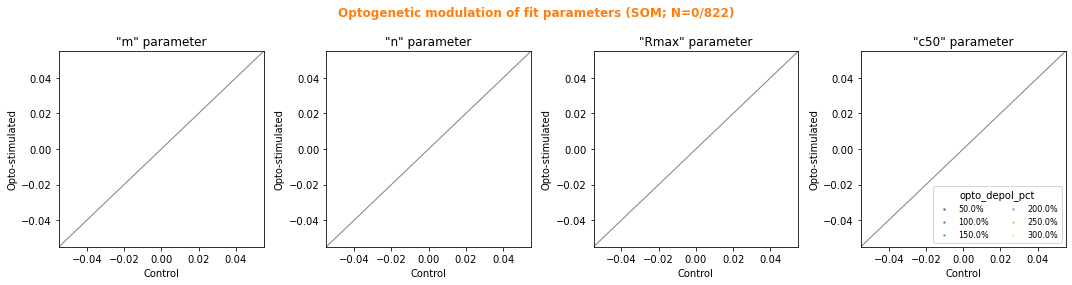

In [130]:
# Plot scatter plots of fitting parameters (Control vs. Opto)
ctrl_idx = np.where(np.array(opto_depol_pct) == 0.0)[0][0]
opto_idx = np.where(np.array(opto_depol_pct) > 0.0)[0]
# opto_idx = [np.where(np.array(opto_depol_pct) > 0.0)[0][0]]

for opt_fit_params, sel_idx, lbl, col in zip([opt_fit_params_PYR, opt_fit_params_PV, opt_fit_params_SOM], [robust_cell_idx_PYR, robust_cell_idx_PV, robust_cell_idx_SOM], ['PYR', 'PV', 'SOM'], ['tab:red', 'tab:blue', 'tab:orange']):
    opt_fit_params = [ofp[sel_idx, :] for ofp in opt_fit_params]
    N = np.sum(np.all(np.isfinite(opt_fit_params[0]), 1))
    plt.figure(figsize=(15, 4))
    for p_idx, p_name in enumerate(fit_param_names):
        plt.subplot(1, len(fit_param_names), p_idx + 1)
        for o_idx in opto_idx:
            plt.plot(opt_fit_params[ctrl_idx][:, p_idx], opt_fit_params[o_idx][:, p_idx], '.', markersize=5, markeredgecolor='none', color=level_colors[o_idx], alpha=0.75, label=f'{opto_depol_pct[o_idx]}%')
        ctrl_mean = np.mean(opt_fit_params[ctrl_idx][:, p_idx])
        opto_means = []
        for o_idx in opto_idx:
            opto_means.append(np.mean(opt_fit_params[o_idx][:, p_idx]))
            plt.plot(ctrl_mean, opto_means[-1], 'D', markersize=5, alpha=0.75, markeredgewidth=0.5, color=level_colors[o_idx], markeredgecolor='k')
#         plt.plot([ctrl_mean] * len(opto_means), opto_means, 'k-', lw=2)
        plt.xlim(plt.xlim())
        plt.ylim(plt.xlim())
#         plt.ylim(plt.ylim())
        ax_min = np.minimum(plt.xlim()[0], plt.ylim()[0])
        ax_max = np.maximum(plt.xlim()[1], plt.ylim()[1])
        plt.plot([ax_min, ax_max], [ax_min, ax_max], '-', lw=1, color='grey', zorder=0)
        plt.xlabel('Control')
        plt.ylabel('Opto-stimulated')
        plt.title(f'"{p_name}" parameter')
    plt.legend(title='opto_depol_pct', ncol=2, loc='lower right', fontsize=8)
    plt.suptitle(f'Optogenetic modulation of fit parameters ({lbl}; N={N}/{len(sel_idx)})', fontweight='bold', color=col)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f'fit_param_scatters_{lbl}.png'), dpi=300)
    plt.show()

### Model fits for direct photostimulation effects

- Model fits for interneuron that are directly photostimulated (PV or SOM)
- Divisive scaling model
- Subtractive shifting model (with rectification)
- Saturating additive model

In [131]:
# Divisive scaling model [Shapiro et al. 2021]
R_div = lambda c, m, n, Rmax, c50, g: R(c, m, n, Rmax, c50) / g
# R_div(c) .......... Amplitude of the evoked response at contrast c during opto stim assuming divisive scaling
# m, n, Rmax, c50 ... Fixed parameter values from tuning curve fits w/o opto stim (control condition)
# g ................. Scaling term [=> To be fitted]

# Subtractive shifting model (with rectification) [Shapiro et al. 2021]
R_sub = lambda c, m, n, Rmax, c50, h: np.maximum(R(c, m, n, Rmax, c50) - h, 0)
# R_sub(c) .......... Amplitude of the evoked response at contrast c during opto stim assuming subtracting shifting
# m, n, Rmax, c50 ... Fixed parameter values from tuning curve fits w/o opto stim (control condition)
# h ................. Shifting term [=> To be fitted]

# Saturating additive model [Shapiro et al. 2021]
R_sat = lambda c, m, n, Rmax, c50, S, A: R(c, m, n, Rmax, c50) + (S * c**-n) / (c**-n + c50**-n) + A
# R_sat(c) .......... Amplitude of the evoked response at contrast c during opto stim assuming a saturating additive model
# m, n, Rmax, c50 ... Fixed parameter values from tuning curve fits w/o opto stim (control condition)
# S, A .............. Saturation/additive terms [=> To be fitted]


In [132]:
# Model fits to explain effects of photostimulation on (normalized) tuning curves [parallel processing]

def div_mod_fit_fct(rp_data):
    """ Divisive model fitting function for looping over data sets.
        Requires: contrasts ... Global definition of #contrasts contrast levels
                  R_div ... Global definitions of divisive scaling model function
    """
    r_data, p_ctrl = rp_data # Unpack tupel: rate data, param. values of control cond.
    R_div_fct = lambda c, g: R_div(c, *p_ctrl, g)
    try:
        p_opt, _ = curve_fit(R_div_fct, contrasts, r_data, p0=[0.5], bounds=(0.0, 2.0), maxfev=100000)
        r_sq = r2_score(r_data, R_div_fct(contrasts, *p_opt)) # Goodness of fit
    except BaseException as e:
        p_opt = np.full(R_div_fct.__code__.co_argcount - 1, np.nan)
        r_sq = np.nan
    return [p_opt, r_sq]


def sub_mod_fit_fct(rp_data):
    """ Subtractive model fitting function for looping over data sets.
        Requires: contrasts ... Global definition of #contrasts contrast levels
                  R_sub ... Global definitions of subtractive shifting model function
                  num_sub_model_params ... Number of subtractive shifting model fitting parameters
    """
    r_data, p_ctrl = rp_data # Unpack tupel: rate data, param. values of control cond.
    R_sub_fct = lambda c, h: R_sub(c, *p_ctrl, h)
    try:
        p_opt, _ = curve_fit(R_sub_fct, contrasts, r_data, p0=[-1.0], bounds=(-np.inf, 2.0), maxfev=100000)
        r_sq = r2_score(r_data, R_sub_fct(contrasts, *p_opt)) # Goodness of fit
    except BaseException as e:
        p_opt = np.full(R_sub_fct.__code__.co_argcount - 1, np.nan)
        r_sq = np.nan
    return [p_opt, r_sq]


def sat_mod_fit_fct(rp_data):
    """ Saturating additive model fitting function for looping over data sets.
        Requires: contrasts ... Global definition of #contrasts contrast levels
                  R_sat ... Global definitions of saturating additive model function
                  num_sat_model_params ... Number of saturating additive model fitting parameters
    """
    r_data, p_ctrl = rp_data # Unpack tupel: rate data, param. values of control cond.
    R_sat_fct = lambda c, S, A: R_sat(c, *p_ctrl, S, A)
    try:
        p_opt, _ = curve_fit(R_sat_fct, contrasts, r_data, p0=[1.0, 1.0], bounds=(-2.0, np.inf), maxfev=100000)
        r_sq = r2_score(r_data, R_sat_fct(contrasts, *p_opt)) # Goodness of fit
    except BaseException as e:
        p_opt = np.full(R_sat_fct.__code__.co_argcount - 1, np.nan)
        r_sq = np.nan
    return [p_opt, r_sq]


def tuning_model_fits(tuning_data, fit_params_control, model_fit_fct, workers=1):
    """Model parameter fitting to (normalized) tuning curve data under photostimulation.
       tuning_data ... List of <#GIDs x #contrasts> arrays for different simulation conditions (e.g., opto stim levels)
       fit_params_control ... <#GIDs x #fit_params> array with optimal fit parameter values (m, n, Rmax, c50) from control condition
       model_fct ... A model fit function that takes tuning rate data and control fit parameters and returns opt. model fit parameter(s)
       Returns: List of same length as tuning_data of <#GIDs x #model_fit_params> arrays (model_fit_param(s): g or h or S/A)
                List of same length as tuning_data of <#GIDs x 1> arrays containing goodness-of-fit estimates (R2 score)
    """
    if workers > 1:
        pool = mp.Pool(workers)
    else:
        pool = None

    mod_fit_params = []
    goodness_of_fits = []
    for data_set in tqdm.tqdm(tuning_data, desc=model_fit_fct.__name__): # Loop over simulation conditions
        if pool is None:
            res = list(map(model_fit_fct, zip(data_set, fit_params_control)))
        else:
            res = pool.map(model_fit_fct, zip(data_set, fit_params_control))
        p_opt = np.array([r[0] for r in res])
        r_sq = np.array([r[1] for r in res])
        mod_fit_params.append(p_opt)
        goodness_of_fits.append(r_sq)

    if pool is not None:
        pool.close()

    return mod_fit_params, goodness_of_fits

In [133]:
# Compute divisive/subtractive/saturation additive model fit parameters (PV)...
# tuning_data_PV = [norm_tuning_curves_PV[sidx]['mean'][:, len(contrasts):] for sidx in range(num_sims)]
# opt_div_model_params_PV, div_model_goodness_of_fits_PV = tuning_model_fits(tuning_data_PV, opt_fit_params_PV[0], div_mod_fit_fct, workers=64)
# np.savez(os.path.join(save_path, 'opt_div_model_params_PV.npz'), opt_div_model_params_PV=opt_div_model_params_PV, div_model_goodness_of_fits_PV=div_model_goodness_of_fits_PV, gids_PV=gids_PV)
# opt_sub_model_params_PV, sub_model_goodness_of_fits_PV = tuning_model_fits(tuning_data_PV, opt_fit_params_PV[0], sub_mod_fit_fct, workers=64)
# np.savez(os.path.join(save_path, 'opt_sub_model_params_PV.npz'), opt_sub_model_params_PV=opt_sub_model_params_PV, sub_model_goodness_of_fits_PV=sub_model_goodness_of_fits_PV, gids_PV=gids_PV)
# opt_sat_model_params_PV, sat_model_goodness_of_fits_PV = tuning_model_fits(tuning_data_PV, opt_fit_params_PV[0], sat_mod_fit_fct, workers=64)
# np.savez(os.path.join(save_path, 'opt_sat_model_params_PV.npz'), opt_sat_model_params_PV=opt_sat_model_params_PV, sat_model_goodness_of_fits_PV=sat_model_goodness_of_fits_PV, gids_PV=gids_PV)

# ...OR load from file
fit_data = np.load(os.path.join(save_path, 'opt_div_model_params_PV.npz'), allow_pickle=True)
opt_div_model_params_PV = list(fit_data['opt_div_model_params_PV'])
div_model_goodness_of_fits_PV = list(fit_data['div_model_goodness_of_fits_PV'])
fit_data = np.load(os.path.join(save_path, 'opt_sub_model_params_PV.npz'), allow_pickle=True)
opt_sub_model_params_PV = list(fit_data['opt_sub_model_params_PV'])
sub_model_goodness_of_fits_PV = list(fit_data['sub_model_goodness_of_fits_PV'])
fit_data = np.load(os.path.join(save_path, 'opt_sat_model_params_PV.npz'), allow_pickle=True)
opt_sat_model_params_PV = list(fit_data['opt_sat_model_params_PV'])
sat_model_goodness_of_fits_PV = list(fit_data['sat_model_goodness_of_fits_PV'])
del fit_data

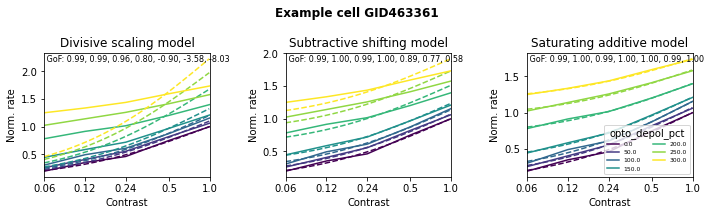

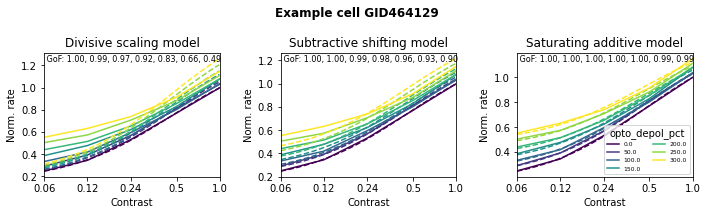

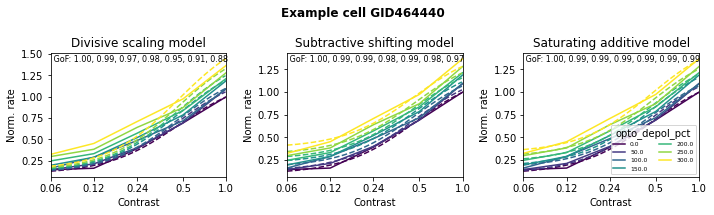

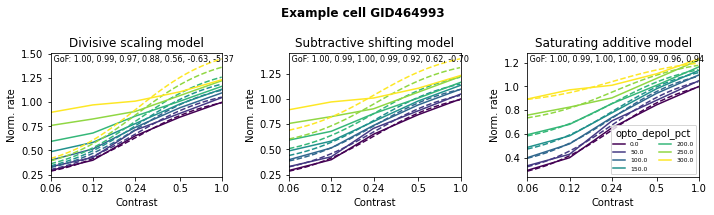

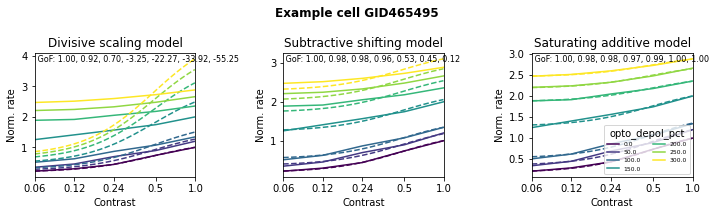

In [134]:
# Plot examples
level_colors = plt.cm.viridis(np.linspace(0, 1, len(opto_depol_pct)))
c = np.arange(min(contrasts), max(contrasts), 0.01)
for ex in range(5):
    sel_idx = np.where(robust_cell_idx_PV)[0][ex]
    plt.figure(figsize=(10, 3))
    model_list = list(zip([R_div, R_sub, R_sat], [opt_div_model_params_PV, opt_sub_model_params_PV, opt_sat_model_params_PV], [div_model_goodness_of_fits_PV, sub_model_goodness_of_fits_PV, sat_model_goodness_of_fits_PV], ['Divisive scaling model', 'Subtractive shifting model', 'Saturating additive model']))
    for midx, (mfct, mparams, mgof, mname) in enumerate(model_list):
        plt.subplot(1, 3, midx + 1)
        for opto_idx, pct in enumerate(opto_depol_pct):
            plt.plot(contrasts, norm_tuning_curves_PV[opto_idx]['mean'][sel_idx, len(contrasts):], color=level_colors[opto_idx, :], label=f'{pct}')
            plt.plot(c, mfct(c, *opt_fit_params_PV[0][sel_idx, :], *mparams[opto_idx][sel_idx, :]), '--', color=level_colors[opto_idx, :])
        plt.xlim([np.min(contrasts), np.max(contrasts)])
        plt.gca().set_xscale('log')
        plt.xticks(contrasts, labels=contrasts)
        plt.gca().minorticks_off()
        plt.xlabel('Contrast')
        plt.ylabel('Norm. rate')
        plt.title(mname)
        plt.text(min(plt.xlim()), 0.99 * max(plt.ylim()), ' GoF: ' + ', '.join([f'{mgof[i][sel_idx]:.2f}' for i in range(num_sims)]), ha='left', va='top', fontsize=8)
    plt.legend(title='opto_depol_pct', ncol=2, loc='lower right', fontsize=6)
    plt.suptitle(f'Example cell GID{gids_PV[sel_idx]}', fontweight='bold')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f'model_fits_example_GID{gids_PV[sel_idx]}.png'), dpi=300)
    plt.show()

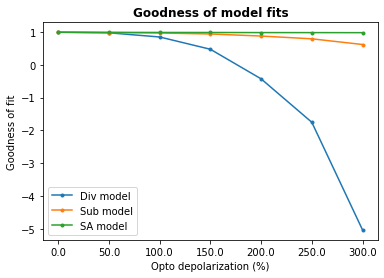

In [135]:
# Plot goodness-of-fits (robust cells only!!)
plt.figure()
plt.plot([np.mean(gof[robust_cell_idx_PV]) for gof in div_model_goodness_of_fits_PV], '.-', label='Div model')
plt.plot([np.mean(gof[robust_cell_idx_PV]) for gof in sub_model_goodness_of_fits_PV], '.-', label='Sub model')
plt.plot([np.mean(gof[robust_cell_idx_PV]) for gof in sat_model_goodness_of_fits_PV], '.-', label='SA model')
plt.xlabel('Opto depolarization (%)')
plt.xticks(np.arange(len(opto_depol_pct)), opto_depol_pct)
plt.ylabel('Goodness of fit')
plt.title('Goodness of model fits', fontweight='bold')
plt.legend()
if save_path is not None:
    plt.savefig(os.path.join(save_path, f'goodness_of_model_fits.png'), dpi=300)
plt.show()

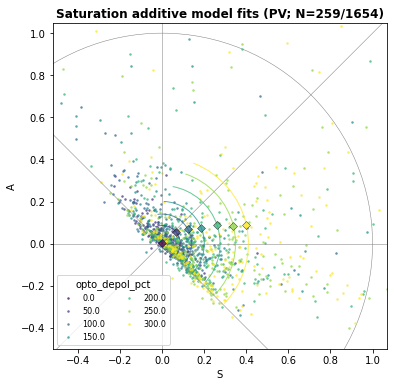

In [136]:
# Polar plot for SA model
sat_r = [np.abs(opt_sat_model_params_PV[i][:, 0] + 1j * opt_sat_model_params_PV[i][:, 1]) for i in range(num_sims)] # Radius
sat_theta = [np.angle(opt_sat_model_params_PV[i][:, 0] + 1j * opt_sat_model_params_PV[i][:, 1]) for i in range(num_sims)] # Angle

r_plot = 1.0 # np.percentile(np.array(sat_r)[:, robust_cell_idx_PV], 99)
plt.figure(figsize=(6, 6))
for opto_idx, pct in enumerate(opto_depol_pct):
    plt.plot(opt_sat_model_params_PV[opto_idx][robust_cell_idx_PV, 0], opt_sat_model_params_PV[opto_idx][robust_cell_idx_PV, 1], '.', markersize=5, markeredgecolor='none', color=level_colors[opto_idx, :], alpha=0.75, label=f'{pct}', zorder=0)
for opto_idx, pct in enumerate(opto_depol_pct):
    mean_r = np.mean(sat_r[opto_idx][robust_cell_idx_PV])
    mean_theta = np.mean(sat_theta[opto_idx][robust_cell_idx_PV])
    std_theta = np.std(sat_theta[opto_idx][robust_cell_idx_PV])
    arc = mpatches.Arc((0, 0), 2 * mean_r, 2 * mean_r, theta1=math.degrees(mean_theta - std_theta), theta2=math.degrees(mean_theta + std_theta), color=level_colors[opto_idx, :], alpha=0.75)
    plt.gca().add_patch(arc)
    plt.plot(np.real(mean_r * np.exp(1j * mean_theta)), np.imag(mean_r * np.exp(1j * mean_theta)), 'D', markersize=5, alpha=0.75, markeredgewidth=0.5, color=level_colors[opto_idx, :], markeredgecolor='k')
circ = plt.Circle((0, 0), r_plot, color='grey', fill=False, lw=0.5, zorder=0)
plt.gca().add_patch(circ)
for phi in [0.0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]:
    plt.plot([-2 * r_plot * np.cos(phi), 2 * r_plot * np.cos(phi)], [-2 * r_plot * np.sin(phi), 2 * r_plot * np.sin(phi)], color='grey', lw=0.5, zorder=0)
plt.axis('equal')
min_lim = np.minimum(np.min(opt_sat_model_params_PV[opto_idx][robust_cell_idx_PV, 0]), np.min(opt_sat_model_params_PV[opto_idx][robust_cell_idx_PV, 1]))
plt.xlim([np.maximum(-0.5, min_lim), r_plot * 1.05])
plt.ylim([np.maximum(-0.5, min_lim), r_plot * 1.05])
plt.xlabel('S')
plt.ylabel('A')
plt.title(f'Saturation additive model fits (PV; N={np.sum(robust_cell_idx_PV)}/{len(robust_cell_idx_PV)})', fontweight='bold')
plt.legend(title='opto_depol_pct', ncol=2, loc='lower left', fontsize=8)
if save_path is not None:
    plt.savefig(os.path.join(save_path, f'sat_model_polar_plot.png'), dpi=300)
plt.show()

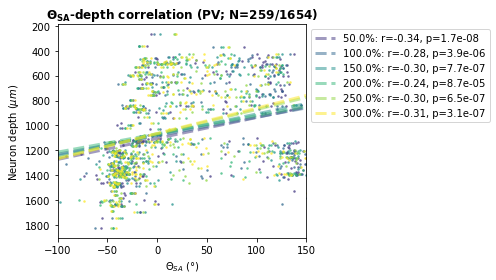

In [137]:
# ThetaSA correlation with neuron depth
depth_um = nrn_depths_PV[robust_cell_idx_PV]
reg_res = []
plt.figure(figsize=(7, 4))
for opto_idx, pct in enumerate(opto_depol_pct):
    if pct == 0.0:
        reg_res.append(None)
        continue
    thetaSA_deg = np.array([math.degrees(rad) for rad in sat_theta[opto_idx][robust_cell_idx_PV]])
    reg_res.append(linregress(thetaSA_deg, depth_um))
    plt.plot(thetaSA_deg, depth_um, '.', markersize=5, markeredgecolor='none', color=level_colors[opto_idx, :], alpha=0.75)
plt.xlim([-100, 150])
plt.ylim(plt.ylim())
x = np.array(plt.xlim())
for opto_idx, (reg, pct) in enumerate(zip(reg_res, opto_depol_pct)):
    if reg is None:
        continue
    plt.plot(x, reg.slope * x + reg.intercept, '--', color=level_colors[opto_idx, :], alpha=0.5, lw=3, label=f'{pct}%: r={reg.rvalue:.2f}, p={reg.pvalue:.1e}')
plt.gca().invert_yaxis()
plt.xlabel('$\Theta_{SA}$ ($\degree$)')
plt.ylabel('Neuron depth ($\mu m$)')
plt.title('$\mathbf{\Theta_{SA}}$-depth correlation ' + f'(PV; N={np.sum(robust_cell_idx_PV)}/{len(robust_cell_idx_PV)})', fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=[1.0, 1.0])
plt.tight_layout()
if save_path is not None:
    plt.savefig(os.path.join(save_path, 'sat_model_depth_corr.png'), dpi=300)
plt.show()

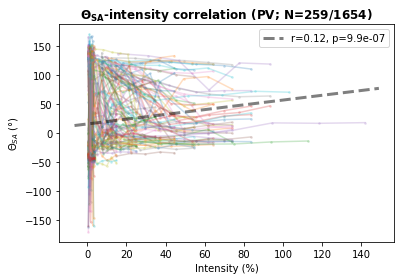

In [138]:
# ThetaSA correlation with actual light intensity
plot_deltas = False # Plots differences between stimulation intensities
thetaSA_deg = []
opto_eff = []
plt.figure()
for pv_idx in np.where(robust_cell_idx_PV)[0]:
    theta = np.array([math.degrees(sat_theta[sidx][pv_idx]) for sidx in range(1, num_sims)])
    strength = opto_strength_eff_PV[pv_idx, 1:]
    if plot_deltas:
        theta = [[0, theta[i + 1] - theta[i]] for i in range(len(theta) - 1)]
        strength = [[0, strength[i + 1] - strength[i]] for i in range(len(strength) - 1)]
    thetaSA_deg.append(theta)
    opto_eff.append(strength)
    plt.plot(np.array(strength).T, np.array(theta).T, '.-', markersize=5, markeredgecolor='none', alpha=0.25)
thetaSA_deg = np.hstack(thetaSA_deg).flatten()
opto_eff = np.hstack(opto_eff).flatten()
reg = linregress(opto_eff, thetaSA_deg)
x = np.array(plt.xlim())
plt.plot(x, reg.slope * x + reg.intercept, '--k', alpha=0.5, lw=3, label=f'r={reg.rvalue:.2f}, p={reg.pvalue:.1e}')
plt.xlabel(('$\Delta$ ' if plot_deltas else '') + 'Intensity (%)')
plt.ylabel(('$\Delta$ ' if plot_deltas else '') + '$\Theta_{SA}$ ($\degree$)')
plt.title('$\mathbf{\Theta_{SA}}$-intensity correlation ' + f'(PV; N={np.sum(robust_cell_idx_PV)}/{len(robust_cell_idx_PV)})', fontweight='bold')
plt.legend()
if save_path is not None:
    plt.savefig(os.path.join(save_path, 'sat_model_' + ('delta_' if plot_deltas else '') + 'intensity_corr.png'), dpi=300)
plt.show()

### Conductance-based model fits of pyramidal neuron responses

- Model fits for pyramidal neurons receiving optogenetically modified inhibitory input
- Saturating additive description of interneurons (PV or SOM)

In [139]:
# Conductance-based model for pyramidal neurons receiving optogenetically modified (saturating additive) inhibitory input [Shapiro et al. 2021]
gL = 6 # Leak conductance (nS)
RL = -50 # Leak reversal potential (mV)
RE = 0 # Excitatory reversal potential (mV)
RI = -65 # Inhibitory reversal potential (mV)
Vr = -50 # Resting potential (mV)
gI_min_offset = 2 # Offset of inhibitory conductance (nS) at low contrast rel. to gE_min [i.e., gI_min = gE_min + gI_min_offset]
gE = lambda c, n, c50, gE_min, gE_max: (gE_max * c**n) / (c**n + c50**n) + gE_min # Excitatory synaptic conductance
gI = lambda c, n, c50, gE_min, gE_max, S, A: gE(c, n, c50, gE_min, gE_max) + (S * c**-n) / (c**-n + c50**-n) + gI_min_offset + A # Inhibitory synaptic conductance
dV = lambda c, n, c50, gE_min, gE_max, S, A: (gL * RL + gE(c, n, c50, gE_min, gE_max) * RE + gI(c, n, c50, gE_min, gE_max, S, A) * RI) / (gL + gE(c, n, c50, gE_min, gE_max) + gI(c, n, c50, gE_min, gE_max, S, A)) - Vr # Membrane potential (mV) as a function of contrast
Vth = 3.4 # Spike threshold (mV)
R_cond = lambda c, n, c50, gE_min, gE_max, S, A: np.maximum((dV(c, n, c50, gE_min, gE_max, S, A) - Vth)**3, 0)
# R_cond(c) ... Amplitude of the evoked response rate at contrast c under a conductance-based model for pyramidal neurons
# n ............ Exponent that determines the steepness of the curve
# c50 .......... Contrast that generates a half-max response elevation
# gE_min/max ... Excitatory conductance at low/high contrast
# S, A ......... Saturation/additive terms


In [140]:
# Model fits to explain modulatory effects of interneuron photostimulation on (normalized) pyramidal neuron tuning curves [parallel processing]
def cond_mod_fit_fct_ctrl(r_data):
    """ Conductance model fitting function on control data for looping over data sets.
        Fitting parameters: n, c50, gE_min, gE_max
        Requires: contrasts ... Global definition of #contrasts contrast levels
                  R_cond ... Global definitions of conductance model function
    """
    R_cond_fct = lambda c, n, c50, gE_min, gE_max: R_cond(c, n, c50, gE_min, gE_max, S=0.0, A=0.0)
    try:
        p_opt, _ = curve_fit(R_cond_fct, contrasts, r_data, p0=[2.0, 0.25, 2.0, 2.0], bounds=(0.0, [np.inf, 1.0, np.inf, np.inf]), maxfev=100000)
        r_sq = r2_score(r_data, R_cond_fct(contrasts, *p_opt)) # Goodness of fit
    except BaseException as e:
        p_opt = np.full(R_cond_fct.__code__.co_argcount - 1, np.nan)
        r_sq = np.nan
    return [p_opt, r_sq]


def cond_mod_fit_fct_opto(rp_data):
    """ Conductance model fitting function on opto stim data for looping over data sets.
        Fitting parameters: S, A (n, c50, gE_min, gE_max kept fixed from control condition)
        Requires: contrasts ... Global definition of #contrasts contrast levels
                  R_cond ... Global definitions of conductance model function
    """
    r_data, p_ctrl = rp_data # Unpack tupel: rate data, param. values of control cond.
    R_cond_fct = lambda c, S, A: R_cond(c, *p_ctrl, S, A)
    try:
        p_opt, _ = curve_fit(R_cond_fct, contrasts, r_data, p0=[0.0, 0.0], bounds=(-2.0, np.inf), maxfev=100000)
        r_sq = r2_score(r_data, R_cond_fct(contrasts, *p_opt)) # Goodness of fit
    except BaseException as e:
        p_opt = np.full(R_cond_fct.__code__.co_argcount - 1, np.nan)
        r_sq = np.nan
    return [p_opt, r_sq]


def cond_model_fits(tuning_data, fit_params_control, workers=1):
    """Model parameter fitting to (normalized) pyramidal cell tuning curve data under interneuron photostimulation.
       tuning_data ... List of <#GIDs x #contrasts> arrays for different simulation conditions (e.g., opto stim levels)
       fit_params_control ... [Optional] <#GIDs x #fit_params> array with optimal fit parameter values (n, c50, gE_min, gE_max) from control condition
       Returns: List of same length as tuning_data of <#GIDs x #model_fit_params> arrays (model_fit_param(s): n/c50/gE_min/gE_max or S/A)
                List of same length as tuning_data of <#GIDs x 1> arrays containing goodness-of-fit estimates (R2 score)
    """
    if workers > 1:
        pool = mp.Pool(workers)
    else:
        pool = None

    mod_fit_params = []
    goodness_of_fits = []
    for data_set in tqdm.tqdm(tuning_data, desc='Control' if fit_params_control is None else 'Opto'): # Loop over simulation conditions
        if fit_params_control is None:
            if pool is None:                
                res = list(map(cond_mod_fit_fct_ctrl, data_set))
            else:
                res = pool.map(cond_mod_fit_fct_ctrl, data_set)
        else:
            if pool is None:                
                res = list(map(cond_mod_fit_fct_opto, zip(data_set, fit_params_control)))
            else:
                res = pool.map(cond_mod_fit_fct_opto, zip(data_set, fit_params_control))
        p_opt = np.array([r[0] for r in res])
        r_sq = np.array([r[1] for r in res])
        mod_fit_params.append(p_opt)
        goodness_of_fits.append(r_sq)

    if pool is not None:
        pool.close()

    return mod_fit_params, goodness_of_fits

In [142]:
# Step 1: Fit model to control data (PYR)
# #   Fitting parameters: n, c50, gE_min, gE_max
# #   S and A set to zero
# tuning_data_PYR = [norm_tuning_curves_PYR[sidx]['mean'][:, len(contrasts):] for sidx in range(num_sims)]
# opt_cond_model_ctrl_params_PYR, cond_model_ctrl_goodness_of_fits_PYR = cond_model_fits(tuning_data_PYR[:1], None, workers=64)

# # Step 2: Fit model to photostimulated data
# #   Fitting parameters: S, A
# #   n, c50, gE_min, gE_max fixed to values estimated from control condition
# opt_cond_model_params_PYR, cond_model_goodness_of_fits_PYR = cond_model_fits(tuning_data_PYR, opt_cond_model_ctrl_params_PYR[0], workers=64)

# np.savez(os.path.join(save_path, 'opt_cond_model_params_PYR.npz'), opt_cond_model_params_PYR=opt_cond_model_params_PYR, cond_model_goodness_of_fits_PYR=cond_model_goodness_of_fits_PYR, opt_cond_model_ctrl_params_PYR=opt_cond_model_ctrl_params_PYR, cond_model_ctrl_goodness_of_fits_PYR=cond_model_ctrl_goodness_of_fits_PYR, gids_PYR=gids_PYR)

# ...OR load from file
fit_data = np.load(os.path.join(save_path, 'opt_cond_model_params_PYR.npz'), allow_pickle=True)
opt_cond_model_params_PYR = list(fit_data['opt_cond_model_params_PYR'])
cond_model_goodness_of_fits_PYR = list(fit_data['cond_model_goodness_of_fits_PYR'])
opt_cond_model_ctrl_params_PYR = list(fit_data['opt_cond_model_ctrl_params_PYR'])
cond_model_ctrl_goodness_of_fits_PYR = list(fit_data['cond_model_ctrl_goodness_of_fits_PYR'])

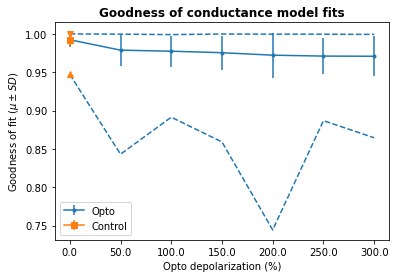

In [143]:
# Plot goodness-of-fits (robust cells only!!)
plt.figure()
# plt.boxplot([gof[robust_cell_idx_PYR] for gof in cond_model_goodness_of_fits_PYR], positions=np.arange(len(opto_depol_pct)))
# plt.plot([np.mean(gof[robust_cell_idx_PYR]) for gof in cond_model_goodness_of_fits_PYR], '.-', color='tab:blue', label='Opto')
plt.errorbar(np.arange(len(opto_depol_pct)), [np.mean(gof[robust_cell_idx_PYR]) for gof in cond_model_goodness_of_fits_PYR], yerr=[np.std(gof[robust_cell_idx_PYR]) for gof in cond_model_goodness_of_fits_PYR], marker='.', color='tab:blue', zorder=0, label='Opto')
plt.plot([np.min(gof[robust_cell_idx_PYR]) for gof in cond_model_goodness_of_fits_PYR], '--', color='tab:blue')
plt.plot([np.max(gof[robust_cell_idx_PYR]) for gof in cond_model_goodness_of_fits_PYR], '--', color='tab:blue')
plt.errorbar(np.arange(len(cond_model_ctrl_goodness_of_fits_PYR)), [np.mean(gof[robust_cell_idx_PYR]) for gof in cond_model_ctrl_goodness_of_fits_PYR], yerr=[np.std(gof[robust_cell_idx_PYR]) for gof in cond_model_ctrl_goodness_of_fits_PYR], marker='s', color='tab:orange', label='Control')
plt.plot([np.min(gof[robust_cell_idx_PYR]) for gof in cond_model_ctrl_goodness_of_fits_PYR], '^', color='tab:orange')
plt.plot([np.max(gof[robust_cell_idx_PYR]) for gof in cond_model_ctrl_goodness_of_fits_PYR], 'v', color='tab:orange')
# plt.boxplot([gof[robust_cell_idx_PYR] for gof in cond_model_ctrl_goodness_of_fits_PYR], positions=np.arange(len(cond_model_ctrl_goodness_of_fits_PYR)))
plt.xlabel('Opto depolarization (%)')
plt.xticks(np.arange(len(opto_depol_pct)), opto_depol_pct)
plt.ylabel('Goodness of fit ($\mu \pm SD$)')
plt.title('Goodness of conductance model fits', fontweight='bold')
plt.legend()
if save_path is not None:
    plt.savefig(os.path.join(save_path, f'goodness_of_cond_model_fits.png'), dpi=300)
plt.show()

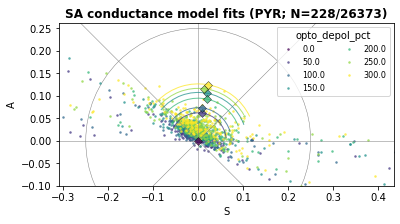

In [144]:
# Polar plot for conductance SA model
sat_r = [np.abs(opt_cond_model_params_PYR[i][:, 0] + 1j * opt_cond_model_params_PYR[i][:, 1]) for i in range(num_sims)] # Radius
sat_theta = [np.angle(opt_cond_model_params_PYR[i][:, 0] + 1j * opt_cond_model_params_PYR[i][:, 1]) for i in range(num_sims)] # Angle

r_plot = 0.25 # np.percentile(np.array(sat_r)[:, robust_cell_idx_PYR], 99)
plt.figure(figsize=(6, 3))
for opto_idx, pct in enumerate(opto_depol_pct):
    plt.plot(opt_cond_model_params_PYR[opto_idx][robust_cell_idx_PYR, 0], opt_cond_model_params_PYR[opto_idx][robust_cell_idx_PYR, 1], '.', markersize=5, markeredgecolor='none', color=level_colors[opto_idx, :], alpha=0.75, label=f'{pct}', zorder=0)
for opto_idx, pct in enumerate(opto_depol_pct):
    mean_r = np.mean(sat_r[opto_idx][robust_cell_idx_PYR])
    mean_theta = np.mean(sat_theta[opto_idx][robust_cell_idx_PYR])
    std_theta = np.std(sat_theta[opto_idx][robust_cell_idx_PYR])
    arc = mpatches.Arc((0, 0), 2 * mean_r, 2 * mean_r, theta1=math.degrees(mean_theta - std_theta), theta2=math.degrees(mean_theta + std_theta), color=level_colors[opto_idx, :], alpha=0.75)
    plt.gca().add_patch(arc)
    plt.plot(np.real(mean_r * np.exp(1j * mean_theta)), np.imag(mean_r * np.exp(1j * mean_theta)), 'D', markersize=5, alpha=0.75, markeredgewidth=0.5, color=level_colors[opto_idx, :], markeredgecolor='k')
circ = plt.Circle((0, 0), r_plot, color='grey', fill=False, lw=0.5, zorder=0)
plt.gca().add_patch(circ)
for phi in [0.0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]:
    plt.plot([-2 * r_plot * np.cos(phi), 2 * r_plot * np.cos(phi)], [-2 * r_plot * np.sin(phi), 2 * r_plot * np.sin(phi)], color='grey', lw=0.5, zorder=0)
plt.axis('equal')
min_lim = np.minimum(np.min(opt_cond_model_params_PYR[opto_idx][robust_cell_idx_PYR, 0]), np.min(opt_cond_model_params_PYR[opto_idx][robust_cell_idx_PYR, 1]))
plt.xlim([np.maximum(-0.25, min_lim), r_plot * 1.5])
plt.ylim([np.maximum(-0.1, min_lim), r_plot * 1.05])
plt.xlabel('S')
plt.ylabel('A')
plt.title(f'SA conductance model fits (PYR; N={np.sum(robust_cell_idx_PYR)}/{len(robust_cell_idx_PYR)})', fontweight='bold')
plt.legend(title='opto_depol_pct', ncol=2, loc='upper right', fontsize=8)
if save_path is not None:
    plt.savefig(os.path.join(save_path, f'cond_sat_model_polar_plot.png'), dpi=300)
plt.show()